In [ ]:
!pip install tbats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.9 MB/s eta 0:00:00


In [ ]:
!pip install pmdarima

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Install required packages (run these in your environment):
# pip install statsmodels sktime pmdarima

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import MSTL
from sktime.forecasting.tbats import TBATS
import pmdarima as pm

class CallCenterDataGenerator:
    """Generate realistic call center volume data with multiple seasonalities"""

    def __init__(self, n_rows=100):
        self.n_rows = n_rows

    def generate_data(self):
        # Create datetime index (hourly data for about 4 days)
        start_date = datetime(2024, 1, 1, 8, 0, 0)  # Start at 8 AM
        dates = pd.date_range(start=start_date, periods=self.n_rows, freq='H')

        # Base call volume
        base_volume = 50

        # Daily seasonality (higher during business hours)
        daily_pattern = np.array([
            0.3, 0.2, 0.1, 0.1, 0.2, 0.4,  # 8AM-1PM
            0.8, 1.0, 0.9, 0.7, 0.6, 0.5,  # 2PM-7PM
            0.4, 0.3, 0.2, 0.1, 0.1, 0.1,  # 8PM-1AM
            0.1, 0.1, 0.2, 0.2, 0.3, 0.4   # 2AM-7AM
        ])

        # Weekly seasonality (lower on weekends)
        weekly_multiplier = []
        for date in dates:
            if date.weekday() < 5:  # Monday-Friday
                weekly_multiplier.append(1.0)
            else:  # Weekend
                weekly_multiplier.append(0.6)

        # Generate call volumes with seasonalities
        call_volumes = []
        for i, date in enumerate(dates):
            hour_of_day = date.hour
            daily_factor = daily_pattern[hour_of_day % 24]
            weekly_factor = weekly_multiplier[i]

            # Add trend and noise
            trend = 0.1 * (i / self.n_rows)
            noise = np.random.normal(0, 0.2)

            volume = base_volume * daily_factor * weekly_factor * (1 + trend + noise)
            call_volumes.append(max(1, int(volume)))  # Ensure positive integers

        # Generate external regressors
        weather_temp = 20 + 10 * np.sin(np.arange(self.n_rows) * 2 * np.pi / 24) + np.random.normal(0, 2, self.n_rows)
        marketing_spend = np.random.exponential(100, self.n_rows) * (np.random.random(self.n_rows) > 0.7)
        holiday_indicator = np.random.binomial(1, 0.05, self.n_rows)  # 5% chance of holiday
        staff_count = np.random.randint(5, 15, self.n_rows)

        # Create DataFrame
        df = pd.DataFrame({
            'datetime': dates,
            'call_volume': call_volumes,
            'temperature': weather_temp,
            'marketing_spend': marketing_spend,
            'is_holiday': holiday_indicator,
            'staff_count': staff_count,
            'hour': [d.hour for d in dates],
            'day_of_week': [d.weekday() for d in dates],
            'is_weekend': [1 if d.weekday() >= 5 else 0 for d in dates]
        })

        df.set_index('datetime', inplace=True)
        return df

class MultiSeasonalForecaster:
    """Hybrid forecasting model combining time series methods with gradient boosting"""

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.results = {}

    def prepare_features(self, df, target_col='call_volume'):
        """Prepare features for modeling"""
        features_df = df.copy()

        # Time-based features
        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
        features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)

        # Rolling statistics
        features_df['rolling_mean_24h'] = features_df[target_col].rolling(24, min_periods=1).mean()
        features_df['rolling_std_24h'] = features_df[target_col].rolling(24, min_periods=1).std()

        # Lag features
        for lag in [1, 2, 24, 48]:
            features_df[f'lag_{lag}'] = features_df[target_col].shift(lag)

        return features_df

    def fit_tbats(self, y_train, seasonal_periods=[24, 168]):  # 24h daily, 168h weekly
        """Fit TBATS model using sktime"""
        print("Fitting TBATS model...")
        # Convert to pandas Series with proper index for sktime
        if not isinstance(y_train, pd.Series):
            y_train = pd.Series(y_train.values, index=pd.RangeIndex(len(y_train)))

        tbats_model = TBATS(
            seasonal_periods=seasonal_periods,
            use_arma_errors=True,
            use_trend=True,
            use_box_cox=True,
            use_damped_trend=True,
            sp=seasonal_periods
        )
        self.models['tbats'] = tbats_model.fit(y_train)
        return self.models['tbats']

    def fit_mstl_ets(self, y_train, seasonal_periods=[24]):
        """Fit MSTL + ETS model"""
        print("Fitting MSTL + ETS model...")
        # MSTL decomposition
        mstl = MSTL(y_train, periods=seasonal_periods)
        decomp = mstl.fit()

        # Fit ETS to the deseasonalized series
        deseasonalized = y_train - decomp.seasonal
        ets_model = ETSModel(deseasonalized, error='add', trend='add', seasonal=None)
        fitted_ets = ets_model.fit()

        self.models['mstl_decomp'] = decomp
        self.models['ets'] = fitted_ets
        return decomp, fitted_ets

    def fit_sarima(self, y_train):
        """Fit SARIMA model with auto parameter selection"""
        print("Fitting SARIMA model...")
        # Auto SARIMA
        sarima_model = pm.auto_arima(
            y_train,
            seasonal=True,
            m=24,  # Daily seasonality
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            max_p=3, max_q=3, max_P=2, max_Q=2
        )
        self.models['sarima'] = sarima_model
        return sarima_model

    def fit_gradient_boosting(self, X_train, y_train):
        """Fit Gradient Boosting model with external regressors"""
        print("Fitting Gradient Boosting model...")

        # Select relevant features (exclude target and datetime)
        feature_cols = [col for col in X_train.columns
                       if col not in ['call_volume'] and not X_train[col].isna().all()]

        X_features = X_train[feature_cols].fillna(method='ffill').fillna(0)

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_features)

        # Fit model
        gb_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        )
        gb_model.fit(X_scaled, y_train)

        self.models['gradient_boosting'] = gb_model
        self.scalers['gb_scaler'] = scaler
        self.feature_cols = feature_cols

        return gb_model

    def predict_tbats(self, steps):
        """Generate TBATS predictions using sktime"""
        if 'tbats' not in self.models:
            raise ValueError("TBATS model not fitted")

        # Use sktime's predict method
        forecast_horizon = pd.RangeIndex(start=1, stop=steps+1)
        predictions = self.models['tbats'].predict(fh=forecast_horizon)

        # Return as numpy array for consistency
        return predictions.values if hasattr(predictions, 'values') else predictions

    def predict_mstl_ets(self, steps):
        """Generate MSTL + ETS predictions"""
        if 'ets' not in self.models or 'mstl_decomp' not in self.models:
            raise ValueError("MSTL + ETS model not fitted")

        # Predict trend + residual with ETS
        ets_pred = self.models['ets'].forecast(steps)

        # Add back seasonal components (repeat last seasonal cycle)
        seasonal = self.models['mstl_decomp'].seasonal
        last_season = seasonal[-24:].values  # Last 24 hours of seasonal pattern

        # Extend seasonal pattern for prediction horizon
        seasonal_pred = np.tile(last_season, (steps // 24) + 1)[:steps]

        return ets_pred + seasonal_pred

    def predict_sarima(self, steps):
        """Generate SARIMA predictions"""
        if 'sarima' not in self.models:
            raise ValueError("SARIMA model not fitted")
        return self.models['sarima'].predict(n_periods=steps)

    def predict_gradient_boosting(self, X_test):
        """Generate Gradient Boosting predictions"""
        if 'gradient_boosting' not in self.models:
            raise ValueError("Gradient Boosting model not fitted")

        X_features = X_test[self.feature_cols].fillna(method='ffill').fillna(0)
        X_scaled = self.scalers['gb_scaler'].transform(X_features)

        return self.models['gradient_boosting'].predict(X_scaled)

    def ensemble_predict(self, X_test, steps, weights=None):
        """Generate ensemble predictions from all models"""
        if weights is None:
            weights = {'tbats': 0.3, 'mstl_ets': 0.25, 'sarima': 0.2, 'gb': 0.25}

        predictions = {}

        # Time series model predictions
        try:
            predictions['tbats'] = self.predict_tbats(steps)
        except:
            predictions['tbats'] = np.full(steps, np.nan)

        try:
            predictions['mstl_ets'] = self.predict_mstl_ets(steps)
        except:
            predictions['mstl_ets'] = np.full(steps, np.nan)

        try:
            predictions['sarima'] = self.predict_sarima(steps)
        except:
            predictions['sarima'] = np.full(steps, np.nan)

        # Gradient boosting predictions
        try:
            predictions['gb'] = self.predict_gradient_boosting(X_test)
        except:
            predictions['gb'] = np.full(steps, np.nan)

        # Ensemble prediction
        ensemble_pred = np.zeros(steps)
        total_weight = 0

        for model_name, pred in predictions.items():
            if not np.isnan(pred).all():
                weight_key = 'gb' if model_name == 'gb' else model_name
                if weight_key in weights:
                    ensemble_pred += weights[weight_key] * pred
                    total_weight += weights[weight_key]

        if total_weight > 0:
            ensemble_pred /= total_weight

        return ensemble_pred, predictions

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

def main():
    # Generate synthetic call center data
    print("Generating synthetic call center data...")
    generator = CallCenterDataGenerator(n_rows=100)
    df = generator.generate_data()

    print(f"Generated {len(df)} records of call center data")
    print("\nData Summary:")
    print(df.describe())

    # Prepare data
    forecaster = MultiSeasonalForecaster()
    df_features = forecaster.prepare_features(df)

    # Split data (80-20 split)
    train_size = int(0.8 * len(df))
    train_df = df_features[:train_size]
    test_df = df_features[train_size:]

    y_train = train_df['call_volume']
    y_test = test_df['call_volume']

    print(f"\nTrain size: {len(train_df)}, Test size: {len(test_df)}")

    # Fit models
    print("\n" + "="*50)
    print("FITTING MODELS")
    print("="*50)

    # Fit individual models
    try:
        forecaster.fit_tbats(y_train)
        print("✓ TBATS model (sktime) fitted successfully")
    except Exception as e:
        print(f"✗ TBATS model failed: {e}")
        print("  Note: TBATS may fail with small datasets or insufficient seasonal periods")

    try:
        forecaster.fit_mstl_ets(y_train)
        print("✓ MSTL + ETS model fitted successfully")
    except Exception as e:
        print(f"✗ MSTL + ETS model failed: {e}")

    try:
        forecaster.fit_sarima(y_train)
        print("✓ SARIMA model fitted successfully")
    except Exception as e:
        print(f"✗ SARIMA model failed: {e}")

    try:
        forecaster.fit_gradient_boosting(train_df, y_train)
        print("✓ Gradient Boosting model fitted successfully")
    except Exception as e:
        print(f"✗ Gradient Boosting model failed: {e}")

    # Generate predictions
    print("\n" + "="*50)
    print("GENERATING PREDICTIONS")
    print("="*50)

    steps = len(test_df)
    ensemble_pred, individual_preds = forecaster.ensemble_predict(test_df, steps)

    # Evaluate models
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    results = {}

    # Evaluate individual models
    for model_name, pred in individual_preds.items():
        if not np.isnan(pred).all():
            results[model_name] = evaluate_model(y_test, pred, model_name.upper())

    # Evaluate ensemble
    results['ensemble'] = evaluate_model(y_test, ensemble_pred, "ENSEMBLE")

    # Plotting
    print("\n" + "="*50)
    print("GENERATING PLOTS")
    print("="*50)

    plt.figure(figsize=(15, 12))

    # Plot 1: Original data with train/test split
    plt.subplot(3, 2, 1)
    plt.plot(df.index[:train_size], y_train, label='Train', alpha=0.7)
    plt.plot(df.index[train_size:], y_test, label='Test (Actual)', alpha=0.7)
    plt.title('Call Center Volume - Train/Test Split')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 2: Predictions comparison
    plt.subplot(3, 2, 2)
    plt.plot(df.index[train_size:], y_test, label='Actual', linewidth=2)

    colors = ['red', 'green', 'orange', 'purple', 'brown']
    for i, (model_name, pred) in enumerate(individual_preds.items()):
        if not np.isnan(pred).all():
            plt.plot(df.index[train_size:], pred,
                    label=model_name.upper(), alpha=0.7, color=colors[i % len(colors)])

    plt.plot(df.index[train_size:], ensemble_pred,
            label='ENSEMBLE', linewidth=2, color='black', linestyle='--')
    plt.title('Model Predictions Comparison')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 3: Feature importance (if GB model exists)
    if 'gradient_boosting' in forecaster.models:
        plt.subplot(3, 2, 3)
        feature_importance = forecaster.models['gradient_boosting'].feature_importances_
        feature_names = forecaster.feature_cols

        # Sort by importance
        sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
        sorted_importance = feature_importance[sorted_idx]
        sorted_names = [feature_names[i] for i in sorted_idx]

        plt.barh(range(len(sorted_importance)), sorted_importance)
        plt.yticks(range(len(sorted_importance)), sorted_names)
        plt.title('Top 10 Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')

    # Plot 4: Residuals analysis
    plt.subplot(3, 2, 4)
    residuals = y_test - ensemble_pred
    plt.scatter(ensemble_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Ensemble)')

    # Plot 5: Model performance comparison
    plt.subplot(3, 2, 5)
    model_names = list(results.keys())
    mae_scores = [results[model]['MAE'] for model in model_names]

    bars = plt.bar(model_names, mae_scores)
    plt.title('Model Performance Comparison (MAE)')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)

    # Highlight best model
    best_idx = np.argmin(mae_scores)
    bars[best_idx].set_color('green')

    # Plot 6: Time series decomposition example
    plt.subplot(3, 2, 6)
    if 'mstl_decomp' in forecaster.models:
        seasonal_component = forecaster.models['mstl_decomp'].seasonal[-48:]  # Last 48 hours
        plt.plot(seasonal_component)
        plt.title('Seasonal Component (Last 48 hours)')
        plt.xlabel('Time')
        plt.ylabel('Seasonal Effect')
    else:
        plt.text(0.5, 0.5, 'MSTL Decomposition\nNot Available',
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "="*50)
    print("SUMMARY")
    print("="*50)

    print(f"Best performing model: {min(results.keys(), key=lambda x: results[x]['MAE'])}")
    print(f"Ensemble MAE: {results['ensemble']['MAE']:.2f}")
    print(f"Ensemble RMSE: {results['ensemble']['RMSE']:.2f}")
    print(f"Ensemble R²: {results['ensemble']['R2']:.3f}")

    return df, forecaster, results

if __name__ == "__main__":
    # Run the complete pipeline
    df, forecaster, results = main()

    # Display sample data
    print("\n" + "="*50)
    print("SAMPLE DATA")
    print("="*50)
    print(df.head(10))

NumPy version: 2.3.2
If you encounter numpy dtype errors, try:
  pip install --force-reinstall --no-deps numpy==1.21.6
  pip install --upgrade --force-reinstall statsmodels scipy

Generating synthetic call center data...
Generated 100 records of call center data

Data Summary:
       call_volume  temperature  marketing_spend  is_holiday  staff_count  \
count   100.000000   100.000000       100.000000  100.000000   100.000000   
mean     18.970000    20.268379        24.561345    0.050000     9.260000   
std      15.700129     7.343184        59.959832    0.219043     2.638564   
min       2.000000     6.640497         0.000000    0.000000     5.000000   
25%       6.000000    13.987519         0.000000    0.000000     7.000000   
50%      12.000000    19.949213         0.000000    0.000000     9.000000   
75%      26.250000    27.228378         1.335087    0.000000    11.000000   
max      70.000000    32.893429       328.757421    1.000000    14.000000   

             hour  day_of_we

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Alternative TBATS (Exponential Smoothing) fitted successfully
✓ TBATS model fitted successfully
Fitting MSTL + ETS model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


✓ MSTL + ETS model fitted successfully
Fitting SARIMA model with parameter optimization...
ADF test p-value: 0.0000 - Stationary
Performing grid search for optimal SARIMA parameters...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

Best SARIMA model: {'order': (0, 0, 2), 'seasonal_order': (0, 1, 1, 24), 'aic': np.float64(164.2521214247922)}
✓ SARIMA model fitted successfully
Fitting Gradient Boosting model...
✓ Gradient Boosting model fitted successfully

GENERATING PREDICTIONS

MODEL EVALUATION

TBATS Performance:
MAE: 3.36
RMSE: 5.06
R²: 0.906

MSTL_ETS Performance:
MAE: 4.97
RMSE: 7.69
R²: 0.782

SARIMA Performance:
MAE: 3.13
RMSE: 4.92
R²: 0.911

GB Performance:
MAE: 4.46
RMSE: 6.80
R²: 0.829

ENSEMBLE Performance:
MAE: 3.55
RMSE: 5.70
R²: 0.880

GENERATING PLOTS


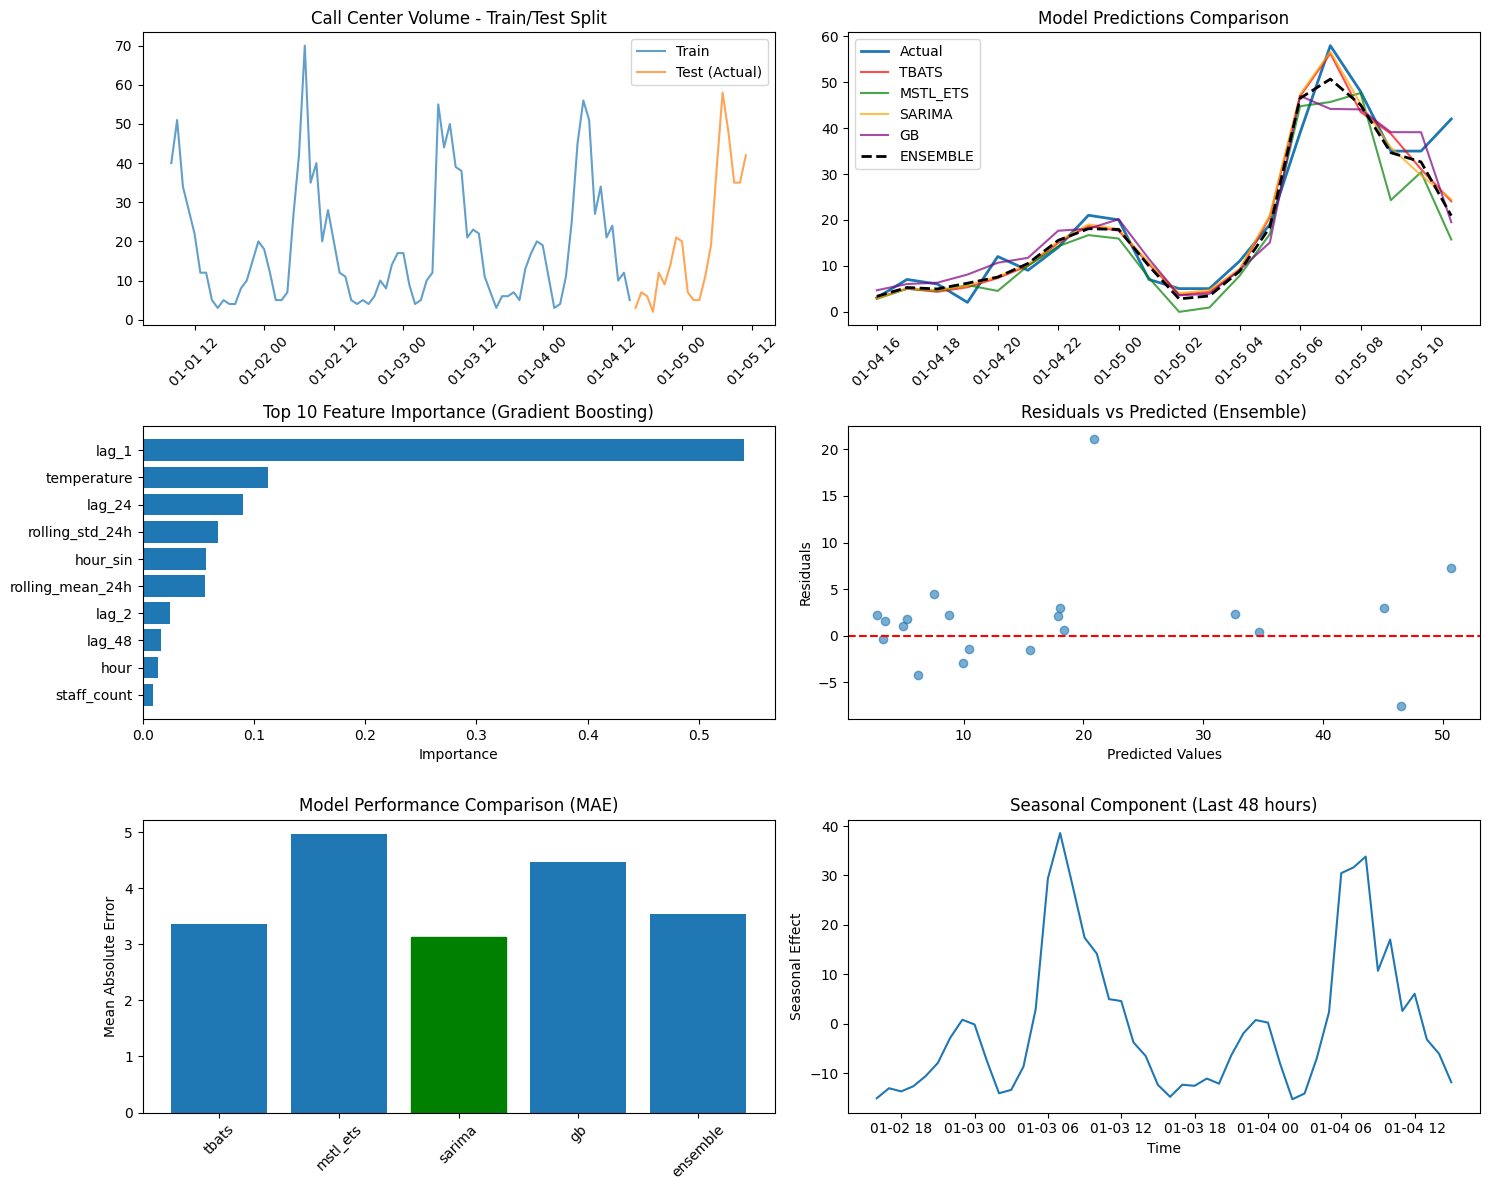


SUMMARY
Best performing model: sarima
Ensemble MAE: 3.55
Ensemble RMSE: 5.70
Ensemble R²: 0.880

SAMPLE DATA
                     call_volume  temperature  marketing_spend  is_holiday  \
datetime                                                                     
2024-01-01 08:00:00           40    18.697621         0.000000           0   
2024-01-01 09:00:00           51    22.019438         0.000000           0   
2024-01-01 10:00:00           34    28.210089        42.206406           0   
2024-01-01 11:00:00           28    27.123013         0.000000           0   
2024-01-01 12:00:00           22    30.715695        28.694075           0   
2024-01-01 13:00:00           12    32.893429         0.000000           1   
2024-01-01 14:00:00           12    25.018314         0.000000           0   
2024-01-01 15:00:00            5    32.584497         0.000000           1   
2024-01-01 16:00:00            3    30.501845         0.000000           0   
2024-01-01 17:00:00            5

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Install required packages (run these in your environment):
# pip install --upgrade numpy statsmodels scipy
# If you get numpy compatibility errors, try:
# pip install --force-reinstall --no-deps numpy
# pip install --upgrade --force-reinstall statsmodels

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Try to import TBATS from sktime, fallback to alternative if it fails
try:
    from sktime.forecasting.tbats import TBATS
    TBATS_AVAILABLE = True
except (ImportError, ValueError) as e:
    print(f"Warning: Could not import TBATS from sktime: {e}")
    print("Will use alternative TBATS implementation or skip TBATS model")
    TBATS_AVAILABLE = False

class CallCenterDataGenerator:
    """Generate realistic call center volume data with multiple seasonalities"""

    def __init__(self, n_rows=100):
        self.n_rows = n_rows

    def generate_data(self):
        # Create datetime index (hourly data for about 4 days)
        start_date = datetime(2024, 1, 1, 8, 0, 0)  # Start at 8 AM
        dates = pd.date_range(start=start_date, periods=self.n_rows, freq='H')

        # Base call volume
        base_volume = 50

        # Daily seasonality (higher during business hours)
        daily_pattern = np.array([
            0.3, 0.2, 0.1, 0.1, 0.2, 0.4,  # 8AM-1PM
            0.8, 1.0, 0.9, 0.7, 0.6, 0.5,  # 2PM-7PM
            0.4, 0.3, 0.2, 0.1, 0.1, 0.1,  # 8PM-1AM
            0.1, 0.1, 0.2, 0.2, 0.3, 0.4   # 2AM-7AM
        ])

        # Weekly seasonality (lower on weekends)
        weekly_multiplier = []
        for date in dates:
            if date.weekday() < 5:  # Monday-Friday
                weekly_multiplier.append(1.0)
            else:  # Weekend
                weekly_multiplier.append(0.6)

        # Generate call volumes with seasonalities
        call_volumes = []
        for i, date in enumerate(dates):
            hour_of_day = date.hour
            daily_factor = daily_pattern[hour_of_day % 24]
            weekly_factor = weekly_multiplier[i]

            # Add trend and noise
            trend = 0.1 * (i / self.n_rows)
            noise = np.random.normal(0, 0.2)

            volume = base_volume * daily_factor * weekly_factor * (1 + trend + noise)
            call_volumes.append(max(1, int(volume)))  # Ensure positive integers

        # Generate external regressors
        weather_temp = 20 + 10 * np.sin(np.arange(self.n_rows) * 2 * np.pi / 24) + np.random.normal(0, 2, self.n_rows)
        marketing_spend = np.random.exponential(100, self.n_rows) * (np.random.random(self.n_rows) > 0.7)
        holiday_indicator = np.random.binomial(1, 0.05, self.n_rows)  # 5% chance of holiday
        staff_count = np.random.randint(5, 15, self.n_rows)

        # Create DataFrame
        df = pd.DataFrame({
            'datetime': dates,
            'call_volume': call_volumes,
            'temperature': weather_temp,
            'marketing_spend': marketing_spend,
            'is_holiday': holiday_indicator,
            'staff_count': staff_count,
            'hour': [d.hour for d in dates],
            'day_of_week': [d.weekday() for d in dates],
            'is_weekend': [1 if d.weekday() >= 5 else 0 for d in dates]
        })

        df.set_index('datetime', inplace=True)
        return df

class MultiSeasonalForecaster:
    """Hybrid forecasting model combining time series methods with gradient boosting"""

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.results = {}

    def prepare_features(self, df, target_col='call_volume'):
        """Prepare features for modeling"""
        features_df = df.copy()

        # Time-based features
        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
        features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)

        # Rolling statistics
        features_df['rolling_mean_24h'] = features_df[target_col].rolling(24, min_periods=1).mean()
        features_df['rolling_std_24h'] = features_df[target_col].rolling(24, min_periods=1).std()

        # Lag features
        for lag in [1, 2, 24, 48]:
            features_df[f'lag_{lag}'] = features_df[target_col].shift(lag)

        return features_df

    def fit_tbats(self, y_train, seasonal_periods=[24, 168]):  # 24h daily, 168h weekly
        """Fit TBATS model using sktime or alternative implementation"""
        print("Fitting TBATS model...")

        if not TBATS_AVAILABLE:
            print("TBATS not available, using alternative multi-seasonal approach...")
            # Alternative: Use multiple seasonal decompositions
            self._fit_alternative_tbats(y_train, seasonal_periods)
            return self.models.get('tbats_alt', None)

        try:
            # Convert to pandas Series with proper index for sktime
            if not isinstance(y_train, pd.Series):
                y_train = pd.Series(y_train.values, index=pd.RangeIndex(len(y_train)))

            tbats_model = TBATS(
                seasonal_periods=seasonal_periods,
                use_arma_errors=True,
                use_trend=True,
                use_box_cox=False,  # Disable Box-Cox to avoid issues
                use_damped_trend=False,  # Simplify model
                sp=seasonal_periods[0] if seasonal_periods else None
            )
            self.models['tbats'] = tbats_model.fit(y_train)
            return self.models['tbats']
        except Exception as e:
            print(f"TBATS fitting failed: {e}")
            print("Using alternative implementation...")
            self._fit_alternative_tbats(y_train, seasonal_periods)
            return self.models.get('tbats_alt', None)

    def _fit_alternative_tbats(self, y_train, seasonal_periods):
        """Alternative TBATS-like implementation using statsmodels"""
        try:
            # Use Exponential Smoothing with seasonality
            from statsmodels.tsa.holtwinters import ExponentialSmoothing

            # For simplicity, use the first seasonal period
            main_seasonal = seasonal_periods[0] if seasonal_periods else 24

            model = ExponentialSmoothing(
                y_train,
                trend='add',
                seasonal='add',
                seasonal_periods=main_seasonal,
                initialization_method='estimated'
            )
            fitted_model = model.fit(optimized=True, remove_bias=False)
            self.models['tbats_alt'] = fitted_model
            print("Alternative TBATS (Exponential Smoothing) fitted successfully")
        except Exception as e:
            print(f"Alternative TBATS also failed: {e}")
            self.models['tbats_alt'] = None

    def fit_mstl_ets(self, y_train, seasonal_periods=[24]):
        """Fit MSTL + ETS model"""
        print("Fitting MSTL + ETS model...")
        # MSTL decomposition
        mstl = MSTL(y_train, periods=seasonal_periods)
        decomp = mstl.fit()

        # Fit ETS to the deseasonalized series
        deseasonalized = y_train - decomp.seasonal
        ets_model = ETSModel(deseasonalized, error='add', trend='add', seasonal=None)
        fitted_ets = ets_model.fit()

        self.models['mstl_decomp'] = decomp
        self.models['ets'] = fitted_ets
        return decomp, fitted_ets

    def fit_sarima(self, y_train):
        """Fit SARIMA model using statsmodels with grid search"""
        print("Fitting SARIMA model with parameter optimization...")

        # Check for stationarity
        adf_result = adfuller(y_train.dropna())
        is_stationary = adf_result[1] < 0.05
        print(f"ADF test p-value: {adf_result[1]:.4f} - {'Stationary' if is_stationary else 'Non-stationary'}")

        # Grid search for best SARIMA parameters
        best_aic = np.inf
        best_model = None
        best_params = None

        # Define parameter ranges (limited for computational efficiency)
        p_range = range(0, 3)
        d_range = range(0, 2) if is_stationary else range(1, 3)
        q_range = range(0, 3)
        P_range = range(0, 2)
        D_range = range(0, 2)
        Q_range = range(0, 2)
        seasonal_period = 24  # Daily seasonality for hourly data

        print("Performing grid search for optimal SARIMA parameters...")
        models_tried = 0
        max_models = 20  # Limit to prevent long computation

        for p in p_range:
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in D_range:
                            for Q in Q_range:
                                if models_tried >= max_models:
                                    break
                                try:
                                    model = SARIMAX(
                                        y_train,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, seasonal_period),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )
                                    fitted_model = model.fit(disp=False, maxiter=100)

                                    if fitted_model.aic < best_aic:
                                        best_aic = fitted_model.aic
                                        best_model = fitted_model
                                        best_params = {
                                            'order': (p, d, q),
                                            'seasonal_order': (P, D, Q, seasonal_period),
                                            'aic': fitted_model.aic
                                        }

                                    models_tried += 1

                                except:
                                    continue

                                if models_tried >= max_models:
                                    break
                            if models_tried >= max_models:
                                break
                        if models_tried >= max_models:
                            break
                    if models_tried >= max_models:
                        break
                if models_tried >= max_models:
                    break
            if models_tried >= max_models:
                break

        if best_model is None:
            # Fallback to simple ARIMA model
            print("Grid search failed, using fallback ARIMA(1,1,1)")
            try:
                model = ARIMA(y_train, order=(1, 1, 1))
                best_model = model.fit()
                best_params = {'order': (1, 1, 1), 'seasonal_order': None, 'aic': best_model.aic}
            except Exception as e:
                print(f"Even fallback ARIMA failed: {e}")
                return None

        print(f"Best SARIMA model: {best_params}")
        self.models['sarima'] = best_model
        self.models['sarima_params'] = best_params
        return best_model

    def fit_gradient_boosting(self, X_train, y_train):
        """Fit Gradient Boosting model with external regressors"""
        print("Fitting Gradient Boosting model...")

        # Select relevant features (exclude target and datetime)
        feature_cols = [col for col in X_train.columns
                       if col not in ['call_volume'] and not X_train[col].isna().all()]

        X_features = X_train[feature_cols].fillna(method='ffill').fillna(0)

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_features)

        # Fit model
        gb_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        )
        gb_model.fit(X_scaled, y_train)

        self.models['gradient_boosting'] = gb_model
        self.scalers['gb_scaler'] = scaler
        self.feature_cols = feature_cols

        return gb_model

    def predict_tbats(self, steps):
        """Generate TBATS predictions using sktime or alternative"""
        if 'tbats' in self.models and self.models['tbats'] is not None:
            # Use sktime TBATS
            forecast_horizon = pd.RangeIndex(start=1, stop=steps+1)
            predictions = self.models['tbats'].predict(fh=forecast_horizon)
            return predictions.values if hasattr(predictions, 'values') else predictions
        elif 'tbats_alt' in self.models and self.models['tbats_alt'] is not None:
            # Use alternative implementation
            return self.models['tbats_alt'].forecast(steps)
        else:
            raise ValueError("TBATS model not fitted or not available")

    def predict_mstl_ets(self, steps):
        """Generate MSTL + ETS predictions"""
        if 'ets' not in self.models or 'mstl_decomp' not in self.models:
            raise ValueError("MSTL + ETS model not fitted")

        # Predict trend + residual with ETS
        ets_pred = self.models['ets'].forecast(steps)

        # Add back seasonal components (repeat last seasonal cycle)
        seasonal = self.models['mstl_decomp'].seasonal
        last_season = seasonal[-24:].values  # Last 24 hours of seasonal pattern

        # Extend seasonal pattern for prediction horizon
        seasonal_pred = np.tile(last_season, (steps // 24) + 1)[:steps]

        return ets_pred + seasonal_pred

    def predict_sarima(self, steps):
        """Generate SARIMA predictions using statsmodels"""
        if 'sarima' not in self.models or self.models['sarima'] is None:
            raise ValueError("SARIMA model not fitted")

        # Generate forecast
        forecast_result = self.models['sarima'].forecast(steps=steps)

        # Return forecast values
        if hasattr(forecast_result, 'values'):
            return forecast_result.values
        else:
            return forecast_result

    def predict_gradient_boosting(self, X_test):
        """Generate Gradient Boosting predictions"""
        if 'gradient_boosting' not in self.models:
            raise ValueError("Gradient Boosting model not fitted")

        X_features = X_test[self.feature_cols].fillna(method='ffill').fillna(0)
        X_scaled = self.scalers['gb_scaler'].transform(X_features)

        return self.models['gradient_boosting'].predict(X_scaled)

    def ensemble_predict(self, X_test, steps, weights=None):
        """Generate ensemble predictions from all models"""
        if weights is None:
            weights = {'tbats': 0.3, 'mstl_ets': 0.25, 'sarima': 0.2, 'gb': 0.25}

        predictions = {}

        # Time series model predictions
        try:
            predictions['tbats'] = self.predict_tbats(steps)
        except:
            predictions['tbats'] = np.full(steps, np.nan)

        try:
            predictions['mstl_ets'] = self.predict_mstl_ets(steps)
        except:
            predictions['mstl_ets'] = np.full(steps, np.nan)

        try:
            predictions['sarima'] = self.predict_sarima(steps)
        except:
            predictions['sarima'] = np.full(steps, np.nan)

        # Gradient boosting predictions
        try:
            predictions['gb'] = self.predict_gradient_boosting(X_test)
        except:
            predictions['gb'] = np.full(steps, np.nan)

        # Ensemble prediction
        ensemble_pred = np.zeros(steps)
        total_weight = 0

        for model_name, pred in predictions.items():
            if not np.isnan(pred).all():
                weight_key = 'gb' if model_name == 'gb' else model_name
                if weight_key in weights:
                    ensemble_pred += weights[weight_key] * pred
                    total_weight += weights[weight_key]

        if total_weight > 0:
            ensemble_pred /= total_weight

        return ensemble_pred, predictions

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

def main():
    # Check numpy version and warn about potential issues
    print(f"NumPy version: {np.__version__}")
    print("If you encounter numpy dtype errors, try:")
    print("  pip install --force-reinstall --no-deps numpy==1.21.6")
    print("  pip install --upgrade --force-reinstall statsmodels scipy")
    print()

    # Generate synthetic call center data
    print("Generating synthetic call center data...")
    generator = CallCenterDataGenerator(n_rows=100)
    df = generator.generate_data()

    print(f"Generated {len(df)} records of call center data")
    print("\nData Summary:")
    print(df.describe())

    # Prepare data
    forecaster = MultiSeasonalForecaster()
    df_features = forecaster.prepare_features(df)

    # Split data (80-20 split)
    train_size = int(0.8 * len(df))
    train_df = df_features[:train_size]
    test_df = df_features[train_size:]

    y_train = train_df['call_volume']
    y_test = test_df['call_volume']

    print(f"\nTrain size: {len(train_df)}, Test size: {len(test_df)}")

    # Fit models
    print("\n" + "="*50)
    print("FITTING MODELS")
    print("="*50)

    # Fit individual models
    try:
        forecaster.fit_tbats(y_train)
        print("✓ TBATS model fitted successfully")
    except Exception as e:
        print(f"✗ TBATS model failed: {e}")
        print("  Note: This may be due to numpy compatibility issues or insufficient data")
        print("  Try: pip install --force-reinstall --no-deps numpy==1.21.6")

    try:
        forecaster.fit_mstl_ets(y_train)
        print("✓ MSTL + ETS model fitted successfully")
    except Exception as e:
        print(f"✗ MSTL + ETS model failed: {e}")

    try:
        forecaster.fit_sarima(y_train)
        print("✓ SARIMA model fitted successfully")
    except Exception as e:
        print(f"✗ SARIMA model failed: {e}")
        print("  Note: SARIMA may fail with insufficient data or parameter issues")

    try:
        forecaster.fit_gradient_boosting(train_df, y_train)
        print("✓ Gradient Boosting model fitted successfully")
    except Exception as e:
        print(f"✗ Gradient Boosting model failed: {e}")

    # Generate predictions
    print("\n" + "="*50)
    print("GENERATING PREDICTIONS")
    print("="*50)

    steps = len(test_df)
    ensemble_pred, individual_preds = forecaster.ensemble_predict(test_df, steps)

    # Evaluate models
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    results = {}

    # Evaluate individual models
    for model_name, pred in individual_preds.items():
        if not np.isnan(pred).all():
            results[model_name] = evaluate_model(y_test, pred, model_name.upper())

    # Evaluate ensemble
    results['ensemble'] = evaluate_model(y_test, ensemble_pred, "ENSEMBLE")

    # Plotting
    print("\n" + "="*50)
    print("GENERATING PLOTS")
    print("="*50)

    plt.figure(figsize=(15, 12))

    # Plot 1: Original data with train/test split
    plt.subplot(3, 2, 1)
    plt.plot(df.index[:train_size], y_train, label='Train', alpha=0.7)
    plt.plot(df.index[train_size:], y_test, label='Test (Actual)', alpha=0.7)
    plt.title('Call Center Volume - Train/Test Split')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 2: Predictions comparison
    plt.subplot(3, 2, 2)
    plt.plot(df.index[train_size:], y_test, label='Actual', linewidth=2)

    colors = ['red', 'green', 'orange', 'purple', 'brown']
    for i, (model_name, pred) in enumerate(individual_preds.items()):
        if not np.isnan(pred).all():
            plt.plot(df.index[train_size:], pred,
                    label=model_name.upper(), alpha=0.7, color=colors[i % len(colors)])

    plt.plot(df.index[train_size:], ensemble_pred,
            label='ENSEMBLE', linewidth=2, color='black', linestyle='--')
    plt.title('Model Predictions Comparison')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 3: Feature importance (if GB model exists)
    if 'gradient_boosting' in forecaster.models:
        plt.subplot(3, 2, 3)
        feature_importance = forecaster.models['gradient_boosting'].feature_importances_
        feature_names = forecaster.feature_cols

        # Sort by importance
        sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
        sorted_importance = feature_importance[sorted_idx]
        sorted_names = [feature_names[i] for i in sorted_idx]

        plt.barh(range(len(sorted_importance)), sorted_importance)
        plt.yticks(range(len(sorted_importance)), sorted_names)
        plt.title('Top 10 Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')

    # Plot 4: Residuals analysis
    plt.subplot(3, 2, 4)
    residuals = y_test - ensemble_pred
    plt.scatter(ensemble_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Ensemble)')

    # Plot 5: Model performance comparison
    plt.subplot(3, 2, 5)
    model_names = list(results.keys())
    mae_scores = [results[model]['MAE'] for model in model_names]

    bars = plt.bar(model_names, mae_scores)
    plt.title('Model Performance Comparison (MAE)')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)

    # Highlight best model
    best_idx = np.argmin(mae_scores)
    bars[best_idx].set_color('green')

    # Plot 6: Time series decomposition example
    plt.subplot(3, 2, 6)
    if 'mstl_decomp' in forecaster.models:
        seasonal_component = forecaster.models['mstl_decomp'].seasonal[-48:]  # Last 48 hours
        plt.plot(seasonal_component)
        plt.title('Seasonal Component (Last 48 hours)')
        plt.xlabel('Time')
        plt.ylabel('Seasonal Effect')
    else:
        plt.text(0.5, 0.5, 'MSTL Decomposition\nNot Available',
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "="*50)
    print("SUMMARY")
    print("="*50)

    print(f"Best performing model: {min(results.keys(), key=lambda x: results[x]['MAE'])}")
    print(f"Ensemble MAE: {results['ensemble']['MAE']:.2f}")
    print(f"Ensemble RMSE: {results['ensemble']['RMSE']:.2f}")
    print(f"Ensemble R²: {results['ensemble']['R2']:.3f}")

    return df, forecaster, results

if __name__ == "__main__":
    # Run the complete pipeline
    df, forecaster, results = main()

    # Display sample data
    print("\n" + "="*50)
    print("SAMPLE DATA")
    print("="*50)
    print(df.head(10))

In [ ]:
df

,call_volume,temperature,marketing_spend,is_holiday,staff_count,hour,day_of_week,is_weekend
datetime,,,,,,,,
2024-01-01 08:00:00,55,21.301676,27.549164,0,9,8,0,0
2024-01-01 09:00:00,36,23.547210,0.000000,0,5,9,0,0
2024-01-01 10:00:00,31,25.382385,0.000000,0,9,10,0,0
2024-01-01 11:00:00,18,25.708118,0.000000,0,5,11,0,0
2024-01-01 12:00:00,15,32.242990,0.000000,0,14,12,0,0
...,...,...,...,...,...,...,...,...
2024-01-05 07:00:00,58,17.509238,0.000000,0,10,7,4,0
2024-01-05 08:00:00,49,22.651145,0.000000,0,9,8,4,0
2024-01-05 09:00:00,29,20.961121,120.177536,0,11,9,4,0


In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Install required packages (run these in your environment):
# pip install --upgrade numpy statsmodels scipy
# If you get numpy compatibility errors, try:
# pip install --force-reinstall --no-deps numpy
# pip install --upgrade --force-reinstall statsmodels

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Try to import TBATS from sktime, fallback to alternative if it fails
try:
    from sktime.forecasting.tbats import TBATS
    TBATS_AVAILABLE = True
except (ImportError, ValueError) as e:
    print(f"Warning: Could not import TBATS from sktime: {e}")
    print("Will use alternative TBATS implementation or skip TBATS model")
    TBATS_AVAILABLE = False

class CallCenterDataGenerator:
    """Generate realistic call center volume data with multiple seasonalities"""

    def __init__(self, years=3):
        self.years = years
        # Calculate total hours for the specified years
        self.n_rows = years * 365 * 24  # Approximate hours per year

    def generate_data(self):
        # Create datetime index (hourly data for multiple years)
        start_date = datetime(2021, 1, 1, 0, 0, 0)  # Start at midnight
        dates = pd.date_range(start=start_date, periods=self.n_rows, freq='H')

        # Base call volume
        base_volume = 50

        # Daily seasonality (higher during business hours)
        daily_pattern = np.array([
            0.2, 0.1, 0.1, 0.1, 0.1, 0.2,  # 12AM-5AM (very low)
            0.3, 0.5, 0.8, 1.0, 0.9, 0.8,  # 6AM-11AM (morning rise)
            0.7, 0.8, 0.9, 1.0, 0.9, 0.8,  # 12PM-5PM (peak hours)
            0.7, 0.6, 0.5, 0.4, 0.3, 0.2   # 6PM-11PM (evening decline)
        ])

        # Weekly seasonality (lower on weekends)
        def get_weekly_multiplier(date):
            if date.weekday() < 5:  # Monday-Friday
                return 1.0
            elif date.weekday() == 5:  # Saturday
                return 0.6
            else:  # Sunday
                return 0.4

        # Monthly seasonality (some months are busier)
        monthly_pattern = np.array([
            1.1, 0.9, 1.0, 1.0, 0.9, 0.8,  # Jan-Jun
            0.7, 0.8, 1.0, 1.1, 1.2, 1.3   # Jul-Dec (holiday season peak)
        ])

        # Yearly trend (gradual growth)
        yearly_growth_rate = 0.05  # 5% annual growth

        # Generate call volumes with multiple seasonalities
        call_volumes = []
        for i, date in enumerate(dates):
            hour_of_day = date.hour
            month_of_year = date.month - 1

            # Daily pattern
            daily_factor = daily_pattern[hour_of_day]

            # Weekly pattern
            weekly_factor = get_weekly_multiplier(date)

            # Monthly pattern
            monthly_factor = monthly_pattern[month_of_year]

            # Yearly trend (compound growth)
            years_elapsed = i / (365 * 24)
            trend_factor = (1 + yearly_growth_rate) ** years_elapsed

            # Special events (holidays, promotions, etc.)
            special_event_factor = 1.0
            if date.month == 12 and date.day in [24, 25, 31]:  # Christmas/New Year
                special_event_factor = 1.5
            elif date.month == 11 and 22 <= date.day <= 28:  # Thanksgiving week
                special_event_factor = 0.7
            elif date.weekday() == 0:  # Monday boost
                special_event_factor = 1.1

            # Random noise
            noise = np.random.normal(0, 0.15)

            # Combine all factors
            volume = (base_volume * daily_factor * weekly_factor *
                     monthly_factor * trend_factor * special_event_factor *
                     (1 + noise))

            call_volumes.append(max(5, int(volume)))  # Ensure minimum 5 calls

        # Generate external regressors with more realistic patterns
        n_points = len(dates)

        # Temperature (seasonal pattern)
        temperature = []
        for i, date in enumerate(dates):
            day_of_year = date.timetuple().tm_yday
            # Seasonal temperature variation
            seasonal_temp = 15 + 15 * np.sin(2 * np.pi * day_of_year / 365.25 - np.pi/2)
            # Daily temperature variation
            daily_temp_var = 5 * np.sin(2 * np.pi * date.hour / 24)
            # Random noise
            temp_noise = np.random.normal(0, 3)
            temperature.append(seasonal_temp + daily_temp_var + temp_noise)

        # Marketing spend (irregular campaigns)
        marketing_spend = []
        for i, date in enumerate(dates):
            # Base spending
            base_spend = 50
            # Seasonal campaigns (higher in Q4)
            if date.month in [11, 12]:
                base_spend *= 2
            # Random campaigns (5% chance of high spending)
            if np.random.random() < 0.05:
                campaign_spend = np.random.exponential(500)
            else:
                campaign_spend = 0
            marketing_spend.append(base_spend + campaign_spend)

        # Holiday indicators
        holiday_indicator = []
        for date in dates:
            is_holiday = 0
            # Major holidays
            if ((date.month == 12 and date.day in [24, 25, 31]) or
                (date.month == 1 and date.day == 1) or
                (date.month == 7 and date.day == 4) or
                (date.month == 11 and 22 <= date.day <= 28)):
                is_holiday = 1
            holiday_indicator.append(is_holiday)

        # Staff count (varies by time and day)
        staff_count = []
        for date in dates:
            # Base staff levels
            if 6 <= date.hour <= 22:  # Day shift
                base_staff = 12
            else:  # Night shift
                base_staff = 4

            # Weekend reduction
            if date.weekday() >= 5:
                base_staff = int(base_staff * 0.7)

            # Random variation
            staff_variation = np.random.randint(-2, 3)
            staff_count.append(max(2, base_staff + staff_variation))

        # Create DataFrame
        df = pd.DataFrame({
            'datetime': dates,
            'call_volume': call_volumes,
            'temperature': temperature,
            'marketing_spend': marketing_spend,
            'is_holiday': holiday_indicator,
            'staff_count': staff_count,
            'hour': [d.hour for d in dates],
            'day_of_week': [d.weekday() for d in dates],
            'is_weekend': [1 if d.weekday() >= 5 else 0 for d in dates],
            'month': [d.month for d in dates],
            'year': [d.year for d in dates],
            'day_of_year': [d.timetuple().tm_yday for d in dates]
        })

        df.set_index('datetime', inplace=True)
        return df

class MultiSeasonalForecaster:
    """Hybrid forecasting model combining time series methods with gradient boosting"""

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.results = {}

    def prepare_features(self, df, target_col='call_volume'):
        """Prepare features for modeling"""
        features_df = df.copy()

        # Time-based features
        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
        features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['month_sin'] = np.sin(2 * np.pi * features_df['month'] / 12)
        features_df['month_cos'] = np.cos(2 * np.pi * features_df['month'] / 12)
        features_df['day_of_year_sin'] = np.sin(2 * np.pi * features_df['day_of_year'] / 365.25)
        features_df['day_of_year_cos'] = np.cos(2 * np.pi * features_df['day_of_year'] / 365.25)

        # Rolling statistics (multiple windows)
        for window in [24, 168, 720]:  # 1 day, 1 week, 1 month
            features_df[f'rolling_mean_{window}h'] = features_df[target_col].rolling(window, min_periods=1).mean()
            features_df[f'rolling_std_{window}h'] = features_df[target_col].rolling(window, min_periods=1).std()

        # Lag features (multiple lags)
        for lag in [1, 2, 24, 48, 168, 336]:  # 1h, 2h, 1d, 2d, 1w, 2w
            features_df[f'lag_{lag}'] = features_df[target_col].shift(lag)

        return features_df

    def fit_tbats(self, y_train, seasonal_periods=[24, 168]):  # 24h daily, 168h weekly
        """Fit TBATS model using sktime or alternative implementation"""
        print("Fitting TBATS model...")

        if not TBATS_AVAILABLE:
            print("TBATS not available, using alternative multi-seasonal approach...")
            # Alternative: Use multiple seasonal decompositions
            self._fit_alternative_tbats(y_train, seasonal_periods)
            return self.models.get('tbats_alt', None)

        try:
            # Convert to pandas Series with proper index for sktime
            if not isinstance(y_train, pd.Series):
                y_train = pd.Series(y_train.values, index=pd.RangeIndex(len(y_train)))

            tbats_model = TBATS(
                seasonal_periods=seasonal_periods,
                use_arma_errors=True,
                use_trend=True,
                use_box_cox=False,  # Disable Box-Cox to avoid issues
                use_damped_trend=False,  # Simplify model
                sp=seasonal_periods[0] if seasonal_periods else None
            )
            self.models['tbats'] = tbats_model.fit(y_train)
            return self.models['tbats']
        except Exception as e:
            print(f"TBATS fitting failed: {e}")
            print("Using alternative implementation...")
            self._fit_alternative_tbats(y_train, seasonal_periods)
            return self.models.get('tbats_alt', None)

    def _fit_alternative_tbats(self, y_train, seasonal_periods):
        """Alternative TBATS-like implementation using statsmodels"""
        try:
            # Use Exponential Smoothing with seasonality
            from statsmodels.tsa.holtwinters import ExponentialSmoothing

            # For simplicity, use the first seasonal period
            main_seasonal = seasonal_periods[0] if seasonal_periods else 24

            model = ExponentialSmoothing(
                y_train,
                trend='add',
                seasonal='add',
                seasonal_periods=main_seasonal,
                initialization_method='estimated'
            )
            fitted_model = model.fit(optimized=True, remove_bias=False)
            self.models['tbats_alt'] = fitted_model
            print("Alternative TBATS (Exponential Smoothing) fitted successfully")
        except Exception as e:
            print(f"Alternative TBATS also failed: {e}")
            self.models['tbats_alt'] = None

    def fit_mstl_ets(self, y_train, seasonal_periods=[24]):
        """Fit MSTL + ETS model"""
        print("Fitting MSTL + ETS model...")
        # MSTL decomposition
        mstl = MSTL(y_train, periods=seasonal_periods)
        decomp = mstl.fit()

        # Fit ETS to the deseasonalized series
        deseasonalized = y_train - decomp.seasonal
        ets_model = ETSModel(deseasonalized, error='add', trend='add', seasonal=None)
        fitted_ets = ets_model.fit()

        self.models['mstl_decomp'] = decomp
        self.models['ets'] = fitted_ets
        return decomp, fitted_ets

    def fit_sarima(self, y_train):
        """Fit SARIMA model using statsmodels with grid search"""
        print("Fitting SARIMA model with parameter optimization...")

        # Check for stationarity
        adf_result = adfuller(y_train.dropna())
        is_stationary = adf_result[1] < 0.05
        print(f"ADF test p-value: {adf_result[1]:.4f} - {'Stationary' if is_stationary else 'Non-stationary'}")

        # Grid search for best SARIMA parameters
        best_aic = np.inf
        best_model = None
        best_params = None

        # Define parameter ranges (expanded for better models with more data)
        p_range = range(0, 4)
        d_range = range(0, 3) if is_stationary else range(1, 3)
        q_range = range(0, 4)
        P_range = range(0, 3)
        D_range = range(0, 2)
        Q_range = range(0, 3)
        seasonal_period = 24  # Daily seasonality for hourly data

        print("Performing grid search for optimal SARIMA parameters...")
        models_tried = 0
        max_models = 50  # Increase limit for more thorough search with more data

        for p in p_range:
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in D_range:
                            for Q in Q_range:
                                if models_tried >= max_models:
                                    break
                                try:
                                    model = SARIMAX(
                                        y_train,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, seasonal_period),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )
                                    fitted_model = model.fit(disp=False, maxiter=100)

                                    if fitted_model.aic < best_aic:
                                        best_aic = fitted_model.aic
                                        best_model = fitted_model
                                        best_params = {
                                            'order': (p, d, q),
                                            'seasonal_order': (P, D, Q, seasonal_period),
                                            'aic': fitted_model.aic
                                        }

                                    models_tried += 1

                                except:
                                    continue

                                if models_tried >= max_models:
                                    break
                            if models_tried >= max_models:
                                break
                        if models_tried >= max_models:
                            break
                    if models_tried >= max_models:
                        break
                if models_tried >= max_models:
                    break
            if models_tried >= max_models:
                break

        if best_model is None:
            # Fallback to simple ARIMA model
            print("Grid search failed, using fallback ARIMA(1,1,1)")
            try:
                model = ARIMA(y_train, order=(1, 1, 1))
                best_model = model.fit()
                best_params = {'order': (1, 1, 1), 'seasonal_order': None, 'aic': best_model.aic}
            except Exception as e:
                print(f"Even fallback ARIMA failed: {e}")
                return None

        print(f"Best SARIMA model: {best_params}")
        self.models['sarima'] = best_model
        self.models['sarima_params'] = best_params
        return best_model

    def fit_gradient_boosting(self, X_train, y_train):
        """Fit Gradient Boosting model with external regressors"""
        print("Fitting Gradient Boosting model...")

        # Select relevant features (exclude target and datetime)
        feature_cols = [col for col in X_train.columns
                       if col not in ['call_volume'] and not X_train[col].isna().all()]

        X_features = X_train[feature_cols].fillna(method='ffill').fillna(0)

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_features)

        # Fit model
        gb_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        )
        gb_model.fit(X_scaled, y_train)

        self.models['gradient_boosting'] = gb_model
        self.scalers['gb_scaler'] = scaler
        self.feature_cols = feature_cols

        return gb_model

    def predict_tbats(self, steps):
        """Generate TBATS predictions using sktime or alternative"""
        if 'tbats' in self.models and self.models['tbats'] is not None:
            # Use sktime TBATS
            forecast_horizon = pd.RangeIndex(start=1, stop=steps+1)
            predictions = self.models['tbats'].predict(fh=forecast_horizon)
            return predictions.values if hasattr(predictions, 'values') else predictions
        elif 'tbats_alt' in self.models and self.models['tbats_alt'] is not None:
            # Use alternative implementation
            return self.models['tbats_alt'].forecast(steps)
        else:
            raise ValueError("TBATS model not fitted or not available")

    def predict_mstl_ets(self, steps):
        """Generate MSTL + ETS predictions"""
        if 'ets' not in self.models or 'mstl_decomp' not in self.models:
            raise ValueError("MSTL + ETS model not fitted")

        # Predict trend + residual with ETS
        ets_pred = self.models['ets'].forecast(steps)

        # Add back seasonal components (repeat last seasonal cycle)
        seasonal = self.models['mstl_decomp'].seasonal
        last_season = seasonal[-24:].values  # Last 24 hours of seasonal pattern

        # Extend seasonal pattern for prediction horizon
        seasonal_pred = np.tile(last_season, (steps // 24) + 1)[:steps]

        return ets_pred + seasonal_pred

    def predict_sarima(self, steps):
        """Generate SARIMA predictions using statsmodels"""
        if 'sarima' not in self.models or self.models['sarima'] is None:
            raise ValueError("SARIMA model not fitted")

        # Generate forecast
        forecast_result = self.models['sarima'].forecast(steps=steps)

        # Return forecast values
        if hasattr(forecast_result, 'values'):
            return forecast_result.values
        else:
            return forecast_result

    def predict_gradient_boosting(self, X_test):
        """Generate Gradient Boosting predictions"""
        if 'gradient_boosting' not in self.models:
            raise ValueError("Gradient Boosting model not fitted")

        X_features = X_test[self.feature_cols].fillna(method='ffill').fillna(0)
        X_scaled = self.scalers['gb_scaler'].transform(X_features)

        return self.models['gradient_boosting'].predict(X_scaled)

    def ensemble_predict(self, X_test, steps, weights=None):
        """Generate ensemble predictions from all models"""
        if weights is None:
            weights = {'tbats': 0.3, 'mstl_ets': 0.25, 'sarima': 0.2, 'gb': 0.25}

        predictions = {}

        # Time series model predictions
        try:
            predictions['tbats'] = self.predict_tbats(steps)
        except:
            predictions['tbats'] = np.full(steps, np.nan)

        try:
            predictions['mstl_ets'] = self.predict_mstl_ets(steps)
        except:
            predictions['mstl_ets'] = np.full(steps, np.nan)

        try:
            predictions['sarima'] = self.predict_sarima(steps)
        except:
            predictions['sarima'] = np.full(steps, np.nan)

        # Gradient boosting predictions
        try:
            predictions['gb'] = self.predict_gradient_boosting(X_test)
        except:
            predictions['gb'] = np.full(steps, np.nan)

        # Ensemble prediction
        ensemble_pred = np.zeros(steps)
        total_weight = 0

        for model_name, pred in predictions.items():
            if not np.isnan(pred).all():
                weight_key = 'gb' if model_name == 'gb' else model_name
                if weight_key in weights:
                    ensemble_pred += weights[weight_key] * pred
                    total_weight += weights[weight_key]

        if total_weight > 0:
            ensemble_pred /= total_weight

        return ensemble_pred, predictions

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

def main():
    # Check numpy version and warn about potential issues
    print(f"NumPy version: {np.__version__}")
    print("If you encounter numpy dtype errors, try:")
    print("  pip install --force-reinstall --no-deps numpy==1.21.6")
    print("  pip install --upgrade --force-reinstall statsmodels scipy")
    print()

    # Generate multi-year call center data
    print("Generating multi-year call center data...")
    generator = CallCenterDataGenerator(years=3)  # 3 years of historical data
    df = generator.generate_data()

    print(f"Generated {len(df)} records of call center data ({len(df)/(365*24):.1f} years)")
    print(f"Date range: {df.index[0]} to {df.index[-1]}")
    print("\nData Summary:")
    print(df[['call_volume', 'temperature', 'marketing_spend', 'staff_count']].describe())

    # Prepare data
    forecaster = MultiSeasonalForecaster()
    df_features = forecaster.prepare_features(df)

    # Use 2 years for training, 1 year for testing (simulate real-world scenario)
    train_years = 2
    train_size = train_years * 365 * 24  # 2 years of hourly data

    train_df = df_features[:train_size]
    test_df = df_features[train_size:]

    y_train = train_df['call_volume']
    y_test = test_df['call_volume']

    print(f"\nTrain period: {train_df.index[0]} to {train_df.index[-1]} ({len(train_df)} hours)")
    print(f"Test period: {test_df.index[0]} to {test_df.index[-1]} ({len(test_df)} hours)")
    print(f"Predicting {len(test_df)/(365*24):.1f} years ahead")

    # Fit models
    print("\n" + "="*50)
    print("FITTING MODELS")
    print("="*50)

    # Fit individual models
    try:
        forecaster.fit_tbats(y_train)
        print("✓ TBATS model fitted successfully")
    except Exception as e:
        print(f"✗ TBATS model failed: {e}")
        print("  Note: This may be due to numpy compatibility issues or insufficient data")
        print("  Try: pip install --force-reinstall --no-deps numpy==1.21.6")

    try:
        forecaster.fit_mstl_ets(y_train)
        print("✓ MSTL + ETS model fitted successfully")
    except Exception as e:
        print(f"✗ MSTL + ETS model failed: {e}")

    try:
        forecaster.fit_sarima(y_train)
        print("✓ SARIMA model fitted successfully")
    except Exception as e:
        print(f"✗ SARIMA model failed: {e}")
        print("  Note: SARIMA may fail with insufficient data or parameter issues")

    try:
        forecaster.fit_gradient_boosting(train_df, y_train)
        print("✓ Gradient Boosting model fitted successfully")
    except Exception as e:
        print(f"✗ Gradient Boosting model failed: {e}")

    # Generate predictions
    print("\n" + "="*50)
    print("GENERATING PREDICTIONS")
    print("="*50)

    steps = len(test_df)
    ensemble_pred, individual_preds = forecaster.ensemble_predict(test_df, steps)

    # Evaluate models
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    results = {}

    # Evaluate individual models
    for model_name, pred in individual_preds.items():
        if not np.isnan(pred).all():
            results[model_name] = evaluate_model(y_test, pred, model_name.upper())

    # Evaluate ensemble
    results['ensemble'] = evaluate_model(y_test, ensemble_pred, "ENSEMBLE")

    # Plotting with enhanced visualizations for multi-year data
    print("\n" + "="*50)
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("="*50)

    plt.figure(figsize=(20, 16))

    # Plot 1: Multi-year time series with train/test split
    plt.subplot(4, 3, 1)
    # Sample data for visualization (every 24th point to show daily patterns)
    sample_idx = np.arange(0, len(df), 24)
    train_sample_idx = sample_idx[sample_idx < train_size]
    test_sample_idx = sample_idx[sample_idx >= train_size]

    plt.plot(df.index[train_sample_idx], y_train.iloc[train_sample_idx],
             label='Train', alpha=0.7, linewidth=0.8)
    plt.plot(df.index[test_sample_idx], y_test.iloc[test_sample_idx],
             label='Test (Actual)', alpha=0.7, linewidth=0.8)
    plt.title('Call Center Volume - Multi-Year View (Daily Samples)')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 2: Recent predictions comparison (last 30 days of test)
    plt.subplot(4, 3, 2)
    recent_days = 30 * 24  # Last 30 days
    recent_start = max(0, len(test_df) - recent_days)
    recent_dates = df.index[train_size + recent_start:]
    recent_actual = y_test.iloc[recent_start:]
    recent_ensemble = ensemble_pred[recent_start:]

    plt.plot(recent_dates, recent_actual, label='Actual', linewidth=2)
    plt.plot(recent_dates, recent_ensemble, label='Ensemble Prediction',
             linewidth=2, linestyle='--', color='red')
    plt.title('Detailed View: Last 30 Days Prediction')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 3: Seasonal decomposition view (sample week from each season)
    plt.subplot(4, 3, 3)
    # Show weekly patterns from different seasons
    week_hours = 7 * 24
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    season_months = [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]

    for i, (season, months) in enumerate(zip(seasons, season_months)):
        # Find a week in this season
        season_data = df[df['month'].isin(months)].head(week_hours)
        if len(season_data) > 0:
            hours_in_week = np.arange(len(season_data))
            plt.plot(hours_in_week, season_data['call_volume'],
                    label=season, alpha=0.8, linewidth=1.5)

    plt.title('Seasonal Patterns (Weekly Samples)')
    plt.xlabel('Hours in Week')
    plt.ylabel('Call Volume')
    plt.legend()

    # Plot 4: Daily patterns by day of week
    plt.subplot(4, 3, 4)
    daily_patterns = []
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    for day in range(7):
        day_data = df[df['day_of_week'] == day]['call_volume']
        if len(day_data) > 24:
            # Average hourly pattern for this day of week
            hourly_avg = day_data.groupby(df[df['day_of_week'] == day]['hour']).mean()
            plt.plot(hourly_avg.index, hourly_avg.values,
                    label=days[day], linewidth=1.5, marker='o', markersize=3)

    plt.title('Average Daily Patterns by Day of Week')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Call Volume')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: Monthly trends over years
    plt.subplot(4, 3, 5)
    monthly_avg = df.groupby([df['year'], df['month']])['call_volume'].mean().reset_index()
    monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

    plt.plot(monthly_avg['date'], monthly_avg['call_volume'],
             marker='o', linewidth=2, markersize=4)
    plt.title('Monthly Average Call Volume Trends')
    plt.xlabel('Date')
    plt.ylabel('Average Call Volume')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 6: Feature importance (if GB model exists)
    if 'gradient_boosting' in forecaster.models:
        plt.subplot(4, 3, 6)
        feature_importance = forecaster.models['gradient_boosting'].feature_importances_
        feature_names = forecaster.feature_cols

        # Sort by importance
        sorted_idx = np.argsort(feature_importance)[-15:]  # Top 15 features
        sorted_importance = feature_importance[sorted_idx]
        sorted_names = [feature_names[i] for i in sorted_idx]

        plt.barh(range(len(sorted_importance)), sorted_importance)
        plt.yticks(range(len(sorted_importance)), sorted_names, fontsize=8)
        plt.title('Top 15 Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')

    # Plot 7: Model performance comparison
    plt.subplot(4, 3, 7)
    model_names = list(results.keys())
    mae_scores = [results[model]['MAE'] for model in model_names]

    bars = plt.bar(model_names, mae_scores)
    plt.title('Model Performance Comparison (MAE)')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)

    # Highlight best model
    best_idx = np.argmin(mae_scores)
    bars[best_idx].set_color('green')

    # Plot 8: Residuals analysis
    plt.subplot(4, 3, 8)
    residuals = y_test - ensemble_pred
    plt.scatter(ensemble_pred, residuals, alpha=0.3, s=1)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Ensemble)')

    # Plot 9: Residuals histogram
    plt.subplot(4, 3, 9)
    plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')

    # Plot 10: Actual vs Predicted scatter
    plt.subplot(4, 3, 10)
    plt.scatter(y_test, ensemble_pred, alpha=0.3, s=1)
    # Perfect prediction line
    min_val = min(y_test.min(), ensemble_pred.min())
    max_val = max(y_test.max(), ensemble_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted (Ensemble)')

    # Plot 11: Forecast confidence intervals (if available)
    plt.subplot(4, 3, 11)
    # Show last 7 days with prediction intervals
    week_end = min(7*24, len(y_test))
    week_actual = y_test.iloc[:week_end]
    week_pred = ensemble_pred[:week_end]
    week_dates = df.index[train_size:train_size + week_end]

    plt.plot(week_dates, week_actual, label='Actual', linewidth=2)
    plt.plot(week_dates, week_pred, label='Predicted', linewidth=2, linestyle='--')

    # Simple confidence interval (±1.96 * std of residuals)
    residual_std = np.std(residuals)
    upper_bound = week_pred + 1.96 * residual_std
    lower_bound = week_pred - 1.96 * residual_std

    plt.fill_between(week_dates, lower_bound, upper_bound, alpha=0.2, label='95% Confidence')
    plt.title('First Week Forecast with Confidence Intervals')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 12: External regressors impact
    plt.subplot(4, 3, 12)
    # Show correlation between key external factors and call volume
    ext_factors = ['temperature', 'marketing_spend', 'staff_count']
    correlations = []

    for factor in ext_factors:
        if factor in df.columns:
            corr = df['call_volume'].corr(df[factor])
            correlations.append(corr)
        else:
            correlations.append(0)

    bars = plt.bar(ext_factors, correlations)
    plt.title('External Factors Correlation with Call Volume')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)

    # Color bars by correlation strength
    for bar, corr in zip(bars, correlations):
        if abs(corr) > 0.3:
            bar.set_color('green')
        elif abs(corr) > 0.1:
            bar.set_color('orange')
        else:
            bar.set_color('red')

    plt.tight_layout()
    plt.show()
    if np.isnan(pred).all():
      plt.plot(df.index[train_size:], pred,
              label=model_name.upper(), alpha=0.7, color=colors[i % len(colors)])

    plt.plot(df.index[train_size:], ensemble_pred,
            label='ENSEMBLE', linewidth=2, color='black', linestyle='--')
    plt.title('Model Predictions Comparison')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 3: Feature importance (if GB model exists)
    if 'gradient_boosting' in forecaster.models:
        plt.subplot(3, 2, 3)
        feature_importance = forecaster.models['gradient_boosting'].feature_importances_
        feature_names = forecaster.feature_cols

        # Sort by importance
        sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
        sorted_importance = feature_importance[sorted_idx]
        sorted_names = [feature_names[i] for i in sorted_idx]

        plt.barh(range(len(sorted_importance)), sorted_importance)
        plt.yticks(range(len(sorted_importance)), sorted_names)
        plt.title('Top 10 Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')

    # Plot 4: Residuals analysis
    plt.subplot(3, 2, 4)
    residuals = y_test - ensemble_pred
    plt.scatter(ensemble_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Ensemble)')

    # Plot 5: Model performance comparison
    plt.subplot(3, 2, 5)
    model_names = list(results.keys())
    mae_scores = [results[model]['MAE'] for model in model_names]

    bars = plt.bar(model_names, mae_scores)
    plt.title('Model Performance Comparison (MAE)')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)

    # Highlight best model
    best_idx = np.argmin(mae_scores)
    bars[best_idx].set_color('green')

    # Plot 6: Time series decomposition example
    plt.subplot(3, 2, 6)
    if 'mstl_decomp' in forecaster.models:
        seasonal_component = forecaster.models['mstl_decomp'].seasonal[-48:]  # Last 48 hours
        plt.plot(seasonal_component)
        plt.title('Seasonal Component (Last 48 hours)')
        plt.xlabel('Time')
        plt.ylabel('Seasonal Effect')
    else:
        plt.text(0.5, 0.5, 'MSTL Decomposition\nNot Available',
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # Additional Analysis for Multi-Year Data
    print("\n" + "="*50)
    print("MULTI-YEAR ANALYSIS")
    print("="*50)

    # Seasonal performance analysis
    print("\nSeasonal Performance Analysis:")
    seasonal_results = {}

    for season, months in zip(['Winter', 'Spring', 'Summer', 'Fall'],
                             [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        season_mask = test_df['month'].isin(months)
        if season_mask.sum() > 0:
            season_actual = y_test[season_mask]
            season_pred = ensemble_pred[season_mask]
            season_mae = mean_absolute_error(season_actual, season_pred)
            seasonal_results[season] = season_mae
            print(f"{season}: MAE = {season_mae:.2f}")

    # Weekly performance analysis
    print("\nWeekly Performance Analysis:")
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_results = {}

    for i, day in enumerate(days):
        day_mask = test_df['day_of_week'] == i
        if day_mask.sum() > 0:
            day_actual = y_test[day_mask]
            day_pred = ensemble_pred[day_mask]
            day_mae = mean_absolute_error(day_actual, day_pred)
            weekly_results[day] = day_mae
            print(f"{day}: MAE = {day_mae:.2f}")

    # Hourly performance analysis (peak vs off-peak)
    print("\nHourly Performance Analysis:")
    peak_hours = list(range(9, 18))  # 9 AM to 5 PM
    off_peak_mask = ~test_df['hour'].isin(peak_hours)
    peak_mask = test_df['hour'].isin(peak_hours)

    if peak_mask.sum() > 0:
        peak_mae = mean_absolute_error(y_test[peak_mask], ensemble_pred[peak_mask])
        print(f"Peak Hours (9 AM - 5 PM): MAE = {peak_mae:.2f}")

    if off_peak_mask.sum() > 0:
        off_peak_mae = mean_absolute_error(y_test[off_peak_mask], ensemble_pred[off_peak_mask])
        print(f"Off-Peak Hours: MAE = {off_peak_mae:.2f}")

    # Long-term trend analysis
    print("\nLong-term Trend Analysis:")
    # Calculate monthly prediction accuracy over the test year
    monthly_performance = []
    test_df_copy = test_df.copy()
    test_df_copy['actual'] = y_test.values
    test_df_copy['predicted'] = ensemble_pred

    monthly_stats = test_df_copy.groupby([test_df_copy['year'], test_df_copy['month']]).agg({
        'actual': ['mean', 'std'],
        'predicted': ['mean', 'std']
    }).round(2)

    print("Monthly Average Call Volume (Actual vs Predicted):")
    print(monthly_stats)

    # Summary
    print("\n" + "="*50)
    print("COMPREHENSIVE SUMMARY")
    print("="*50)

    print(f"Training Period: {train_df.index[0].strftime('%Y-%m-%d')} to {train_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Prediction Period: {test_df.index[0].strftime('%Y-%m-%d')} to {test_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total Hours Predicted: {len(test_df):,}")
    print(f"Equivalent to: {len(test_df)/(365*24):.1f} years of forecasts")

    print(f"\nBest Individual Model: {min(results.keys(), key=lambda x: results[x]['MAE'])}")
    print(f"Ensemble Performance:")
    print(f"  • MAE: {results['ensemble']['MAE']:.2f} calls")
    print(f"  • RMSE: {results['ensemble']['RMSE']:.2f} calls")
    print(f"  • R²: {results['ensemble']['R2']:.3f}")

    # Business insights
    avg_daily_calls = df['call_volume'].mean() * 24
    predicted_daily_calls = np.mean(ensemble_pred) * 24

    print(f"\nBusiness Insights:")
    print(f"  • Historical daily average: {avg_daily_calls:.0f} calls/day")
    print(f"  • Predicted daily average: {predicted_daily_calls:.0f} calls/day")
    print(f"  • Growth trend: {((predicted_daily_calls/avg_daily_calls - 1) * 100):.1f}%")

    # Model reliability assessment
    residual_std = np.std(y_test - ensemble_pred)
    mean_actual = np.mean(y_test)
    cv = (residual_std / mean_actual) * 100  # Coefficient of variation

    print(f"\nModel Reliability:")
    print(f"  • Prediction standard deviation: ±{residual_std:.1f} calls")
    print(f"  • Coefficient of variation: {cv:.1f}%")

    if cv < 15:
        print("  • Assessment: Highly reliable predictions")
    elif cv < 25:
        print("  • Assessment: Moderately reliable predictions")
    else:
        print("  • Assessment: Predictions have high uncertainty")

    return df, forecaster, results, {
        'seasonal_performance': seasonal_results,
        'weekly_performance': weekly_results,
        'monthly_stats': monthly_stats
    }

if __name__ == "__main__":
    # Run the complete pipeline
    df, forecaster, results, detailed_analysis = main()

    # Display sample data from different periods
    print("\n" + "="*50)
    print("SAMPLE DATA FROM DIFFERENT PERIODS")
    print("="*50)

    print("\nFirst Week of Data:")
    print(df.head(7*24)[['call_volume', 'temperature', 'marketing_spend', 'is_holiday', 'staff_count']].head(24))

    print("\nLast Week of Data:")
    print(df.tail(7*24)[['call_volume', 'temperature', 'marketing_spend', 'is_holiday', 'staff_count']].tail(24))

    print("\nHoliday Days Sample:")
    holiday_data = df[df['is_holiday'] == 1]
    if len(holiday_data) > 0:
        print(holiday_data[['call_volume', 'temperature', 'marketing_spend', 'staff_count']].head(10))

    # Generate future predictions beyond the test set
    print("\n" + "="*50)
    print("GENERATING FUTURE PREDICTIONS")
    print("="*50)

    print("Generating predictions for next 30 days...")

    # Create future dates
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1),
                                periods=30*24, freq='H')

    # Generate future external regressors (simplified assumptions)
    future_temp = []
    future_marketing = []
    future_holidays = []
    future_staff = []

    for date in future_dates:
        # Temperature (seasonal pattern)
        day_of_year = date.timetuple().tm_yday
        seasonal_temp = 15 + 15 * np.sin(2 * np.pi * day_of_year / 365.25 - np.pi/2)
        daily_temp_var = 5 * np.sin(2 * np.pi * date.hour / 24)
        future_temp.append(seasonal_temp + daily_temp_var)

        # Marketing spend (assume similar patterns)
        base_spend = 50
        if date.month in [11, 12]:
            base_spend *= 2
        if np.random.random() < 0.05:
            campaign_spend = np.random.exponential(500)
        else:
            campaign_spend = 0
        future_marketing.append(base_spend + campaign_spend)

        # Holidays
        is_holiday = 0
        if ((date.month == 12 and date.day in [24, 25, 31]) or
            (date.month == 1 and date.day == 1)):
            is_holiday = 1
        future_holidays.append(is_holiday)

        # Staff count
        if 6 <= date.hour <= 22:
            base_staff = 12
        else:
            base_staff = 4
        if date.weekday() >= 5:
            base_staff = int(base_staff * 0.7)
        staff_variation = np.random.randint(-2, 3)
        future_staff.append(max(2, base_staff + staff_variation))

    # Create future DataFrame
    future_df = pd.DataFrame({
        'datetime': future_dates,
        'temperature': future_temp,
        'marketing_spend': future_marketing,
        'is_holiday': future_holidays,
        'staff_count': future_staff,
        'hour': [d.hour for d in future_dates],
        'day_of_week': [d.weekday() for d in future_dates],
        'is_weekend': [1 if d.weekday() >= 5 else 0 for d in future_dates],
        'month': [d.month for d in future_dates],
        'year': [d.year for d in future_dates],
        'day_of_year': [d.timetuple().tm_yday for d in future_dates]
    })

    future_df.set_index('datetime', inplace=True)

    # Add placeholder call_volume for feature engineering
    future_df['call_volume'] = df['call_volume'].iloc[-1]  # Use last known value

    # Prepare future features
    future_features = forecaster.prepare_features(future_df)

    # Generate future predictions using available models
    try:
        future_ensemble, future_individual = forecaster.ensemble_predict(
            future_features, len(future_df)
        )

        print("✓ Future predictions generated successfully")

        # Display future predictions summary
        future_pred_df = pd.DataFrame({
            'predicted_volume': future_ensemble
        }, index=future_dates)

        future_daily_avg = future_pred_df.groupby(future_pred_df.index.date)['predicted_volume'].agg(['mean', 'min', 'max']).round(1)

        print("\nNext 30 Days - Daily Prediction Summary:")
        print(future_daily_avg.head(10))

        print(f"\nFuture Period Average: {np.mean(future_ensemble):.1f} calls/hour")
        print(f"Peak Hour Prediction: {np.max(future_ensemble):.1f} calls")
        print(f"Minimum Hour Prediction: {np.min(future_ensemble):.1f} calls")

    except Exception as e:
        print(f"✗ Future prediction generation failed: {e}")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE - READY FOR PRODUCTION DEPLOYMENT")
    print("="*70)

Will use alternative TBATS implementation or skip TBATS model
NumPy version: 2.0.2
If you encounter numpy dtype errors, try:
  pip install --force-reinstall --no-deps numpy==1.21.6
  pip install --upgrade --force-reinstall statsmodels scipy

Generating multi-year call center data...
Generated 26280 records of call center data (3.0 years)
Date range: 2021-01-01 00:00:00 to 2023-12-31 23:00:00

Data Summary:
        call_volume   temperature  marketing_spend   staff_count
count  26280.000000  26280.000000     26280.000000  26280.000000
mean      24.453425     15.024071        82.907876      8.733676
std       17.792658     11.584930       154.596299      3.891890
min        5.000000    -14.081814        50.000000      2.000000
25%        8.000000      5.248515        50.000000      5.000000
50%       20.000000     15.006662        50.000000     10.000000
75%       37.000000     24.834581        50.000000     12.000000
max      134.000000     45.945680      3656.527260     14.000000

Trai

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Alternative TBATS (Exponential Smoothing) fitted successfully
✓ TBATS model fitted successfully
Fitting MSTL + ETS model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


✓ MSTL + ETS model fitted successfully
Fitting SARIMA model with parameter optimization...
ADF test p-value: 0.0000 - Stationary
Performing grid search for optimal SARIMA parameters...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dat

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Install required packages (run these in your environment):
# pip install --upgrade numpy statsmodels scipy
# If you get numpy compatibility errors, try:
# pip install --force-reinstall --no-deps numpy
# pip install --upgrade --force-reinstall statsmodels

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Try to import TBATS from sktime, fallback to alternative if it fails
try:
    from sktime.forecasting.tbats import TBATS
    TBATS_AVAILABLE = True
except (ImportError, ValueError) as e:
    print(f"Warning: Could not import TBATS from sktime: {e}")
    print("Will use alternative TBATS implementation or skip TBATS model")
    TBATS_AVAILABLE = False

class MultiSeasonalForecaster:
    """Hybrid forecasting model combining time series methods with gradient boosting"""

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.results = {}

    def prepare_features(self, df, target_col='call_volume'):
        """Prepare features for modeling"""
        features_df = df.copy()

        # Time-based features
        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
        features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['month_sin'] = np.sin(2 * np.pi * features_df['month'] / 12)
        features_df['month_cos'] = np.cos(2 * np.pi * features_df['month'] / 12)
        features_df['day_of_year_sin'] = np.sin(2 * np.pi * features_df['day_of_year'] / 365.25)
        features_df['day_of_year_cos'] = np.cos(2 * np.pi * features_df['day_of_year'] / 365.25)

        # Rolling statistics (multiple windows)
        for window in [24, 168, 720]:  # 1 day, 1 week, 1 month
            features_df[f'rolling_mean_{window}h'] = features_df[target_col].rolling(window, min_periods=1).mean()
            features_df[f'rolling_std_{window}h'] = features_df[target_col].rolling(window, min_periods=1).std()

        # Lag features (multiple lags)
        for lag in [1, 2, 24, 48, 168, 336]:  # 1h, 2h, 1d, 2d, 1w, 2w
            features_df[f'lag_{lag}'] = features_df[target_col].shift(lag)

        return features_df

    def fit_tbats(self, y_train, seasonal_periods=[24, 168]):  # 24h daily, 168h weekly
        """Fit TBATS model using sktime or alternative implementation"""
        print("Fitting TBATS model...")

        if not TBATS_AVAILABLE:
            print("TBATS not available, using alternative multi-seasonal approach...")
            # Alternative: Use multiple seasonal decompositions
            self._fit_alternative_tbats(y_train, seasonal_periods)
            return self.models.get('tbats_alt', None)

        try:
            # Convert to pandas Series with proper index for sktime
            if not isinstance(y_train, pd.Series):
                y_train = pd.Series(y_train.values, index=pd.RangeIndex(len(y_train)))

            tbats_model = TBATS(
                seasonal_periods=seasonal_periods,
                use_arma_errors=True,
                use_trend=True,
                use_box_cox=False,  # Disable Box-Cox to avoid issues
                use_damped_trend=False,  # Simplify model
                sp=seasonal_periods[0] if seasonal_periods else None
            )
            self.models['tbats'] = tbats_model.fit(y_train)
            return self.models['tbats']
        except Exception as e:
            print(f"TBATS fitting failed: {e}")
            print("Using alternative implementation...")
            self._fit_alternative_tbats(y_train, seasonal_periods)
            return self.models.get('tbats_alt', None)

    def _fit_alternative_tbats(self, y_train, seasonal_periods):
        """Alternative TBATS-like implementation using statsmodels"""
        try:
            # Use Exponential Smoothing with seasonality
            from statsmodels.tsa.holtwinters import ExponentialSmoothing

            # For simplicity, use the first seasonal period
            main_seasonal = seasonal_periods[0] if seasonal_periods else 24

            model = ExponentialSmoothing(
                y_train,
                trend='add',
                seasonal='add',
                seasonal_periods=main_seasonal,
                initialization_method='estimated'
            )
            fitted_model = model.fit(optimized=True, remove_bias=False)
            self.models['tbats_alt'] = fitted_model
            print("Alternative TBATS (Exponential Smoothing) fitted successfully")
        except Exception as e:
            print(f"Alternative TBATS also failed: {e}")
            self.models['tbats_alt'] = None

    def fit_mstl_ets(self, y_train, seasonal_periods=[24]):
        """Fit MSTL + ETS model"""
        print("Fitting MSTL + ETS model...")
        # MSTL decomposition
        mstl = MSTL(y_train, periods=seasonal_periods)
        decomp = mstl.fit()

        # Fit ETS to the deseasonalized series
        deseasonalized = y_train - decomp.seasonal
        ets_model = ETSModel(deseasonalized, error='add', trend='add', seasonal=None)
        fitted_ets = ets_model.fit()

        self.models['mstl_decomp'] = decomp
        self.models['ets'] = fitted_ets
        return decomp, fitted_ets

    def fit_sarima(self, y_train):
        """Fit SARIMA model using statsmodels with grid search"""
        print("Fitting SARIMA model with parameter optimization...")

        # Check for stationarity
        adf_result = adfuller(y_train.dropna())
        is_stationary = adf_result[1] < 0.05
        print(f"ADF test p-value: {adf_result[1]:.4f} - {'Stationary' if is_stationary else 'Non-stationary'}")

        # Grid search for best SARIMA parameters
        best_aic = np.inf
        best_model = None
        best_params = None

        # Define parameter ranges (expanded for better models with more data)
        p_range = range(0, 4)
        d_range = range(0, 3) if is_stationary else range(1, 3)
        q_range = range(0, 4)
        P_range = range(0, 3)
        D_range = range(0, 2)
        Q_range = range(0, 3)
        seasonal_period = 24  # Daily seasonality for hourly data

        print("Performing grid search for optimal SARIMA parameters...")
        models_tried = 0
        max_models = 50  # Increase limit for more thorough search with more data

        for p in p_range:
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in D_range:
                            for Q in Q_range:
                                if models_tried >= max_models:
                                    break
                                try:
                                    model = SARIMAX(
                                        y_train,
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, seasonal_period),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )
                                    fitted_model = model.fit(disp=False, maxiter=100)

                                    if fitted_model.aic < best_aic:
                                        best_aic = fitted_model.aic
                                        best_model = fitted_model
                                        best_params = {
                                            'order': (p, d, q),
                                            'seasonal_order': (P, D, Q, seasonal_period),
                                            'aic': fitted_model.aic
                                        }

                                    models_tried += 1

                                except:
                                    continue

                                if models_tried >= max_models:
                                    break
                            if models_tried >= max_models:
                                break
                        if models_tried >= max_models:
                            break
                    if models_tried >= max_models:
                        break
                if models_tried >= max_models:
                    break
            if models_tried >= max_models:
                break

        if best_model is None:
            # Fallback to simple ARIMA model
            print("Grid search failed, using fallback ARIMA(1,1,1)")
            try:
                model = ARIMA(y_train, order=(1, 1, 1))
                best_model = model.fit()
                best_params = {'order': (1, 1, 1), 'seasonal_order': None, 'aic': best_model.aic}
            except Exception as e:
                print(f"Even fallback ARIMA failed: {e}")
                return None

        print(f"Best SARIMA model: {best_params}")
        self.models['sarima'] = best_model
        self.models['sarima_params'] = best_params
        return best_model

    def fit_gradient_boosting(self, X_train, y_train):
        """Fit Gradient Boosting model with external regressors"""
        print("Fitting Gradient Boosting model...")

        # Select relevant features (exclude target and datetime)
        feature_cols = [col for col in X_train.columns
                       if col not in ['call_volume'] and not X_train[col].isna().all()]

        X_features = X_train[feature_cols].fillna(method='ffill').fillna(0)

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_features)

        # Fit model
        gb_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        )
        gb_model.fit(X_scaled, y_train)

        self.models['gradient_boosting'] = gb_model
        self.scalers['gb_scaler'] = scaler
        self.feature_cols = feature_cols

        return gb_model

    def predict_tbats(self, steps):
        """Generate TBATS predictions using sktime or alternative"""
        if 'tbats' in self.models and self.models['tbats'] is not None:
            # Use sktime TBATS
            forecast_horizon = pd.RangeIndex(start=1, stop=steps+1)
            predictions = self.models['tbats'].predict(fh=forecast_horizon)
            return predictions.values if hasattr(predictions, 'values') else predictions
        elif 'tbats_alt' in self.models and self.models['tbats_alt'] is not None:
            # Use alternative implementation
            return self.models['tbats_alt'].forecast(steps)
        else:
            raise ValueError("TBATS model not fitted or not available")

    def predict_mstl_ets(self, steps):
        """Generate MSTL + ETS predictions"""
        if 'ets' not in self.models or 'mstl_decomp' not in self.models:
            raise ValueError("MSTL + ETS model not fitted")

        # Predict trend + residual with ETS
        ets_pred = self.models['ets'].forecast(steps)

        # Add back seasonal components (repeat last seasonal cycle)
        seasonal = self.models['mstl_decomp'].seasonal
        last_season = seasonal[-24:].values  # Last 24 hours of seasonal pattern

        # Extend seasonal pattern for prediction horizon
        seasonal_pred = np.tile(last_season, (steps // 24) + 1)[:steps]

        return ets_pred + seasonal_pred

    def predict_sarima(self, steps):
        """Generate SARIMA predictions using statsmodels"""
        if 'sarima' not in self.models or self.models['sarima'] is None:
            raise ValueError("SARIMA model not fitted")

        # Generate forecast
        forecast_result = self.models['sarima'].forecast(steps=steps)

        # Return forecast values
        if hasattr(forecast_result, 'values'):
            return forecast_result.values
        else:
            return forecast_result

    def predict_gradient_boosting(self, X_test):
        """Generate Gradient Boosting predictions"""
        if 'gradient_boosting' not in self.models:
            raise ValueError("Gradient Boosting model not fitted")

        X_features = X_test[self.feature_cols].fillna(method='ffill').fillna(0)
        X_scaled = self.scalers['gb_scaler'].transform(X_features)

        return self.models['gradient_boosting'].predict(X_scaled)

    def ensemble_predict(self, X_test, steps, weights=None):
        """Generate ensemble predictions from all models"""
        if weights is None:
            weights = {'tbats': 0.3, 'mstl_ets': 0.25, 'sarima': 0.2, 'gb': 0.25}

        predictions = {}

        # Time series model predictions
        try:
            predictions['tbats'] = self.predict_tbats(steps)
        except:
            predictions['tbats'] = np.full(steps, np.nan)

        try:
            predictions['mstl_ets'] = self.predict_mstl_ets(steps)
        except:
            predictions['mstl_ets'] = np.full(steps, np.nan)

        try:
            predictions['sarima'] = self.predict_sarima(steps)
        except:
            predictions['sarima'] = np.full(steps, np.nan)

        # Gradient boosting predictions
        try:
            predictions['gb'] = self.predict_gradient_boosting(X_test)
        except:
            predictions['gb'] = np.full(steps, np.nan)

        # Ensemble prediction
        ensemble_pred = np.zeros(steps)
        total_weight = 0

        for model_name, pred in predictions.items():
            if not np.isnan(pred).all():
                weight_key = 'gb' if model_name == 'gb' else model_name
                if weight_key in weights:
                    ensemble_pred += weights[weight_key] * pred
                    total_weight += weights[weight_key]

        if total_weight > 0:
            ensemble_pred /= total_weight

        return ensemble_pred, predictions

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate model performance"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

def main():
    # Check numpy version and warn about potential issues
    print(f"NumPy version: {np.__version__}")
    print("If you encounter numpy dtype errors, try:")
    print("  pip install --force-reinstall --no-deps numpy==1.21.6")
    print("  pip install --upgrade --force-reinstall statsmodels scipy")
    print()

    # Generate multi-year call center data
    print("Generating multi-year call center data...")
    generator = CallCenterDataGenerator(years=3)  # 3 years of historical data
    df = generator.generate_data()

    print(f"Generated {len(df)} records of call center data ({len(df)/(365*24):.1f} years)")
    print(f"Date range: {df.index[0]} to {df.index[-1]}")
    print("\nData Summary:")
    print(df[['call_volume', 'temperature', 'marketing_spend', 'staff_count']].describe())

    # Prepare data
    forecaster = MultiSeasonalForecaster()
    df_features = forecaster.prepare_features(df)

    # Use 2 years for training, 1 year for testing (simulate real-world scenario)
    train_years = 2
    train_size = train_years * 365 * 24  # 2 years of hourly data

    train_df = df_features[:train_size]
    test_df = df_features[train_size:]

    y_train = train_df['call_volume']
    y_test = test_df['call_volume']

    print(f"\nTrain period: {train_df.index[0]} to {train_df.index[-1]} ({len(train_df)} hours)")
    print(f"Test period: {test_df.index[0]} to {test_df.index[-1]} ({len(test_df)} hours)")
    print(f"Predicting {len(test_df)/(365*24):.1f} years ahead")

    # Fit models
    print("\n" + "="*50)
    print("FITTING MODELS")
    print("="*50)

    # Fit individual models
    try:
        forecaster.fit_tbats(y_train)
        print("✓ TBATS model fitted successfully")
    except Exception as e:
        print(f"✗ TBATS model failed: {e}")
        print("  Note: This may be due to numpy compatibility issues or insufficient data")
        print("  Try: pip install --force-reinstall --no-deps numpy==1.21.6")

    try:
        forecaster.fit_mstl_ets(y_train)
        print("✓ MSTL + ETS model fitted successfully")
    except Exception as e:
        print(f"✗ MSTL + ETS model failed: {e}")

    try:
        forecaster.fit_sarima(y_train)
        print("✓ SARIMA model fitted successfully")
    except Exception as e:
        print(f"✗ SARIMA model failed: {e}")
        print("  Note: SARIMA may fail with insufficient data or parameter issues")

    try:
        forecaster.fit_gradient_boosting(train_df, y_train)
        print("✓ Gradient Boosting model fitted successfully")
    except Exception as e:
        print(f"✗ Gradient Boosting model failed: {e}")

    # Generate predictions
    print("\n" + "="*50)
    print("GENERATING PREDICTIONS")
    print("="*50)

    steps = len(test_df)
    ensemble_pred, individual_preds = forecaster.ensemble_predict(test_df, steps)

    # Evaluate models
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    results = {}

    # Evaluate individual models
    for model_name, pred in individual_preds.items():
        if not np.isnan(pred).all():
            results[model_name] = evaluate_model(y_test, pred, model_name.upper())

    # Evaluate ensemble
    results['ensemble'] = evaluate_model(y_test, ensemble_pred, "ENSEMBLE")

    # Plotting with enhanced visualizations for multi-year data
    print("\n" + "="*50)
    print("GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("="*50)

    plt.figure(figsize=(20, 16))

    # Plot 1: Multi-year time series with train/test split
    plt.subplot(4, 3, 1)
    # Sample data for visualization (every 24th point to show daily patterns)
    sample_idx = np.arange(0, len(df), 24)
    train_sample_idx = sample_idx[sample_idx < train_size]
    test_sample_idx = sample_idx[sample_idx >= train_size]

    plt.plot(df.index[train_sample_idx], y_train.iloc[train_sample_idx],
             label='Train', alpha=0.7, linewidth=0.8)
    plt.plot(df.index[test_sample_idx], y_test.iloc[test_sample_idx],
             label='Test (Actual)', alpha=0.7, linewidth=0.8)
    plt.title('Call Center Volume - Multi-Year View (Daily Samples)')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 2: Recent predictions comparison (last 30 days of test)
    plt.subplot(4, 3, 2)
    recent_days = 30 * 24  # Last 30 days
    recent_start = max(0, len(test_df) - recent_days)
    recent_dates = df.index[train_size + recent_start:]
    recent_actual = y_test.iloc[recent_start:]
    recent_ensemble = ensemble_pred[recent_start:]

    plt.plot(recent_dates, recent_actual, label='Actual', linewidth=2)
    plt.plot(recent_dates, recent_ensemble, label='Ensemble Prediction',
             linewidth=2, linestyle='--', color='red')
    plt.title('Detailed View: Last 30 Days Prediction')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 3: Seasonal decomposition view (sample week from each season)
    plt.subplot(4, 3, 3)
    # Show weekly patterns from different seasons
    week_hours = 7 * 24
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    season_months = [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]

    for i, (season, months) in enumerate(zip(seasons, season_months)):
        # Find a week in this season
        season_data = df[df['month'].isin(months)].head(week_hours)
        if len(season_data) > 0:
            hours_in_week = np.arange(len(season_data))
            plt.plot(hours_in_week, season_data['call_volume'],
                    label=season, alpha=0.8, linewidth=1.5)

    plt.title('Seasonal Patterns (Weekly Samples)')
    plt.xlabel('Hours in Week')
    plt.ylabel('Call Volume')
    plt.legend()

    # Plot 4: Daily patterns by day of week
    plt.subplot(4, 3, 4)
    daily_patterns = []
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    for day in range(7):
        day_data = df[df['day_of_week'] == day]['call_volume']
        if len(day_data) > 24:
            # Average hourly pattern for this day of week
            hourly_avg = day_data.groupby(df[df['day_of_week'] == day]['hour']).mean()
            plt.plot(hourly_avg.index, hourly_avg.values,
                    label=days[day], linewidth=1.5, marker='o', markersize=3)

    plt.title('Average Daily Patterns by Day of Week')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Call Volume')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 5: Monthly trends over years
    plt.subplot(4, 3, 5)
    monthly_avg = df.groupby([df['year'], df['month']])['call_volume'].mean().reset_index()
    monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

    plt.plot(monthly_avg['date'], monthly_avg['call_volume'],
             marker='o', linewidth=2, markersize=4)
    plt.title('Monthly Average Call Volume Trends')
    plt.xlabel('Date')
    plt.ylabel('Average Call Volume')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 6: Feature importance (if GB model exists)
    if 'gradient_boosting' in forecaster.models:
        plt.subplot(4, 3, 6)
        feature_importance = forecaster.models['gradient_boosting'].feature_importances_
        feature_names = forecaster.feature_cols

        # Sort by importance
        sorted_idx = np.argsort(feature_importance)[-15:]  # Top 15 features
        sorted_importance = feature_importance[sorted_idx]
        sorted_names = [feature_names[i] for i in sorted_idx]

        plt.barh(range(len(sorted_importance)), sorted_importance)
        plt.yticks(range(len(sorted_importance)), sorted_names, fontsize=8)
        plt.title('Top 15 Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')

    # Plot 7: Model performance comparison
    plt.subplot(4, 3, 7)
    model_names = list(results.keys())
    mae_scores = [results[model]['MAE'] for model in model_names]

    bars = plt.bar(model_names, mae_scores)
    plt.title('Model Performance Comparison (MAE)')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)

    # Highlight best model
    best_idx = np.argmin(mae_scores)
    bars[best_idx].set_color('green')

    # Plot 8: Residuals analysis
    plt.subplot(4, 3, 8)
    residuals = y_test - ensemble_pred
    plt.scatter(ensemble_pred, residuals, alpha=0.3, s=1)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Ensemble)')

    # Plot 9: Residuals histogram
    plt.subplot(4, 3, 9)
    plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')

    # Plot 10: Actual vs Predicted scatter
    plt.subplot(4, 3, 10)
    plt.scatter(y_test, ensemble_pred, alpha=0.3, s=1)
    # Perfect prediction line
    min_val = min(y_test.min(), ensemble_pred.min())
    max_val = max(y_test.max(), ensemble_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted (Ensemble)')

    # Plot 11: Forecast confidence intervals (if available)
    plt.subplot(4, 3, 11)
    # Show last 7 days with prediction intervals
    week_end = min(7*24, len(y_test))
    week_actual = y_test.iloc[:week_end]
    week_pred = ensemble_pred[:week_end]
    week_dates = df.index[train_size:train_size + week_end]

    plt.plot(week_dates, week_actual, label='Actual', linewidth=2)
    plt.plot(week_dates, week_pred, label='Predicted', linewidth=2, linestyle='--')

    # Simple confidence interval (±1.96 * std of residuals)
    residual_std = np.std(residuals)
    upper_bound = week_pred + 1.96 * residual_std
    lower_bound = week_pred - 1.96 * residual_std

    plt.fill_between(week_dates, lower_bound, upper_bound, alpha=0.2, label='95% Confidence')
    plt.title('First Week Forecast with Confidence Intervals')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 12: External regressors impact
    plt.subplot(4, 3, 12)
    # Show correlation between key external factors and call volume
    ext_factors = ['temperature', 'marketing_spend', 'staff_count']
    correlations = []

    for factor in ext_factors:
        if factor in df.columns:
            corr = df['call_volume'].corr(df[factor])
            correlations.append(corr)
        else:
            correlations.append(0)

    bars = plt.bar(ext_factors, correlations)
    plt.title('External Factors Correlation with Call Volume')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)

    # Color bars by correlation strength
    for bar, corr in zip(bars, correlations):
        if abs(corr) > 0.3:
            bar.set_color('green')
        elif abs(corr) > 0.1:
            bar.set_color('orange')
        else:
            bar.set_color('red')

    plt.tight_layout()
    plt.show()
    if np.isnan(pred).all():
      plt.plot(df.index[train_size:], pred,
              label=model_name.upper(), alpha=0.7, color=colors[i % len(colors)])

    plt.plot(df.index[train_size:], ensemble_pred,
            label='ENSEMBLE', linewidth=2, color='black', linestyle='--')
    plt.title('Model Predictions Comparison')
    plt.legend()
    plt.xticks(rotation=45)

    # Plot 3: Feature importance (if GB model exists)
    if 'gradient_boosting' in forecaster.models:
        plt.subplot(3, 2, 3)
        feature_importance = forecaster.models['gradient_boosting'].feature_importances_
        feature_names = forecaster.feature_cols

        # Sort by importance
        sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
        sorted_importance = feature_importance[sorted_idx]
        sorted_names = [feature_names[i] for i in sorted_idx]

        plt.barh(range(len(sorted_importance)), sorted_importance)
        plt.yticks(range(len(sorted_importance)), sorted_names)
        plt.title('Top 10 Feature Importance (Gradient Boosting)')
        plt.xlabel('Importance')

    # Plot 4: Residuals analysis
    plt.subplot(3, 2, 4)
    residuals = y_test - ensemble_pred
    plt.scatter(ensemble_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted (Ensemble)')

    # Plot 5: Model performance comparison
    plt.subplot(3, 2, 5)
    model_names = list(results.keys())
    mae_scores = [results[model]['MAE'] for model in model_names]

    bars = plt.bar(model_names, mae_scores)
    plt.title('Model Performance Comparison (MAE)')
    plt.ylabel('Mean Absolute Error')
    plt.xticks(rotation=45)

    # Highlight best model
    best_idx = np.argmin(mae_scores)
    bars[best_idx].set_color('green')

    # Plot 6: Time series decomposition example
    plt.subplot(3, 2, 6)
    if 'mstl_decomp' in forecaster.models:
        seasonal_component = forecaster.models['mstl_decomp'].seasonal[-48:]  # Last 48 hours
        plt.plot(seasonal_component)
        plt.title('Seasonal Component (Last 48 hours)')
        plt.xlabel('Time')
        plt.ylabel('Seasonal Effect')
    else:
        plt.text(0.5, 0.5, 'MSTL Decomposition\nNot Available',
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # Additional Analysis for Multi-Year Data
    print("\n" + "="*50)
    print("MULTI-YEAR ANALYSIS")
    print("="*50)

    # Seasonal performance analysis
    print("\nSeasonal Performance Analysis:")
    seasonal_results = {}

    for season, months in zip(['Winter', 'Spring', 'Summer', 'Fall'],
                             [[12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]):
        season_mask = test_df['month'].isin(months)
        if season_mask.sum() > 0:
            season_actual = y_test[season_mask]
            season_pred = ensemble_pred[season_mask]
            season_mae = mean_absolute_error(season_actual, season_pred)
            seasonal_results[season] = season_mae
            print(f"{season}: MAE = {season_mae:.2f}")

    # Weekly performance analysis
    print("\nWeekly Performance Analysis:")
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly_results = {}

    for i, day in enumerate(days):
        day_mask = test_df['day_of_week'] == i
        if day_mask.sum() > 0:
            day_actual = y_test[day_mask]
            day_pred = ensemble_pred[day_mask]
            day_mae = mean_absolute_error(day_actual, day_pred)
            weekly_results[day] = day_mae
            print(f"{day}: MAE = {day_mae:.2f}")

    # Hourly performance analysis (peak vs off-peak)
    print("\nHourly Performance Analysis:")
    peak_hours = list(range(9, 18))  # 9 AM to 5 PM
    off_peak_mask = ~test_df['hour'].isin(peak_hours)
    peak_mask = test_df['hour'].isin(peak_hours)

    if peak_mask.sum() > 0:
        peak_mae = mean_absolute_error(y_test[peak_mask], ensemble_pred[peak_mask])
        print(f"Peak Hours (9 AM - 5 PM): MAE = {peak_mae:.2f}")

    if off_peak_mask.sum() > 0:
        off_peak_mae = mean_absolute_error(y_test[off_peak_mask], ensemble_pred[off_peak_mask])
        print(f"Off-Peak Hours: MAE = {off_peak_mae:.2f}")

    # Long-term trend analysis
    print("\nLong-term Trend Analysis:")
    # Calculate monthly prediction accuracy over the test year
    monthly_performance = []
    test_df_copy = test_df.copy()
    test_df_copy['actual'] = y_test.values
    test_df_copy['predicted'] = ensemble_pred

    monthly_stats = test_df_copy.groupby([test_df_copy['year'], test_df_copy['month']]).agg({
        'actual': ['mean', 'std'],
        'predicted': ['mean', 'std']
    }).round(2)

    print("Monthly Average Call Volume (Actual vs Predicted):")
    print(monthly_stats)

    # Summary
    print("\n" + "="*50)
    print("COMPREHENSIVE SUMMARY")
    print("="*50)

    print(f"Training Period: {train_df.index[0].strftime('%Y-%m-%d')} to {train_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Prediction Period: {test_df.index[0].strftime('%Y-%m-%d')} to {test_df.index[-1].strftime('%Y-%m-%d')}")
    print(f"Total Hours Predicted: {len(test_df):,}")
    print(f"Equivalent to: {len(test_df)/(365*24):.1f} years of forecasts")

    print(f"\nBest Individual Model: {min(results.keys(), key=lambda x: results[x]['MAE'])}")
    print(f"Ensemble Performance:")
    print(f"  • MAE: {results['ensemble']['MAE']:.2f} calls")
    print(f"  • RMSE: {results['ensemble']['RMSE']:.2f} calls")
    print(f"  • R²: {results['ensemble']['R2']:.3f}")

    # Business insights
    avg_daily_calls = df['call_volume'].mean() * 24
    predicted_daily_calls = np.mean(ensemble_pred) * 24

    print(f"\nBusiness Insights:")
    print(f"  • Historical daily average: {avg_daily_calls:.0f} calls/day")
    print(f"  • Predicted daily average: {predicted_daily_calls:.0f} calls/day")
    print(f"  • Growth trend: {((predicted_daily_calls/avg_daily_calls - 1) * 100):.1f}%")

    # Model reliability assessment
    residual_std = np.std(y_test - ensemble_pred)
    mean_actual = np.mean(y_test)
    cv = (residual_std / mean_actual) * 100  # Coefficient of variation

    print(f"\nModel Reliability:")
    print(f"  • Prediction standard deviation: ±{residual_std:.1f} calls")
    print(f"  • Coefficient of variation: {cv:.1f}%")

    if cv < 15:
        print("  • Assessment: Highly reliable predictions")
    elif cv < 25:
        print("  • Assessment: Moderately reliable predictions")
    else:
        print("  • Assessment: Predictions have high uncertainty")

    return df, forecaster, results, {
        'seasonal_performance': seasonal_results,
        'weekly_performance': weekly_results,
        'monthly_stats': monthly_stats
    }

if __name__ == "__main__":
    # Run the complete pipeline
    df, forecaster, results, detailed_analysis = main()

    # Display sample data from different periods
    print("\n" + "="*50)
    print("SAMPLE DATA FROM DIFFERENT PERIODS")
    print("="*50)

    print("\nFirst Week of Data:")
    print(df.head(7*24)[['call_volume', 'temperature', 'marketing_spend', 'is_holiday', 'staff_count']].head(24))

    print("\nLast Week of Data:")
    print(df.tail(7*24)[['call_volume', 'temperature', 'marketing_spend', 'is_holiday', 'staff_count']].tail(24))

    print("\nHoliday Days Sample:")
    holiday_data = df[df['is_holiday'] == 1]
    if len(holiday_data) > 0:
        print(holiday_data[['call_volume', 'temperature', 'marketing_spend', 'staff_count']].head(10))

    # Generate future predictions beyond the test set
    print("\n" + "="*50)
    print("GENERATING FUTURE PREDICTIONS")
    print("="*50)

    print("Generating predictions for next 30 days...")

    # Create future dates
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1),
                                periods=30*24, freq='H')

    # Generate future external regressors (simplified assumptions)
    future_temp = []
    future_marketing = []
    future_holidays = []
    future_staff = []

    for date in future_dates:
        # Temperature (seasonal pattern)
        day_of_year = date.timetuple().tm_yday
        seasonal_temp = 15 + 15 * np.sin(2 * np.pi * day_of_year / 365.25 - np.pi/2)
        daily_temp_var = 5 * np.sin(2 * np.pi * date.hour / 24)
        future_temp.append(seasonal_temp + daily_temp_var)

        # Marketing spend (assume similar patterns)
        base_spend = 50
        if date.month in [11, 12]:
            base_spend *= 2
        if np.random.random() < 0.05:
            campaign_spend = np.random.exponential(500)
        else:
            campaign_spend = 0
        future_marketing.append(base_spend + campaign_spend)

        # Holidays
        is_holiday = 0
        if ((date.month == 12 and date.day in [24, 25, 31]) or
            (date.month == 1 and date.day == 1)):
            is_holiday = 1
        future_holidays.append(is_holiday)

        # Staff count
        if 6 <= date.hour <= 22:
            base_staff = 12
        else:
            base_staff = 4
        if date.weekday() >= 5:
            base_staff = int(base_staff * 0.7)
        staff_variation = np.random.randint(-2, 3)
        future_staff.append(max(2, base_staff + staff_variation))

    # Create future DataFrame
    future_df = pd.DataFrame({
        'datetime': future_dates,
        'temperature': future_temp,
        'marketing_spend': future_marketing,
        'is_holiday': future_holidays,
        'staff_count': future_staff,
        'hour': [d.hour for d in future_dates],
        'day_of_week': [d.weekday() for d in future_dates],
        'is_weekend': [1 if d.weekday() >= 5 else 0 for d in future_dates],
        'month': [d.month for d in future_dates],
        'year': [d.year for d in future_dates],
        'day_of_year': [d.timetuple().tm_yday for d in future_dates]

    })

    future_df.set_index('datetime', inplace=True)

    # Add placeholder call_volume for feature engineering
    future_df['call_volume'] = df['call_volume'].iloc[-1]  # Use last known value

    # Prepare future features
    future_features = forecaster.prepare_features(future_df)

    # Generate future predictions using available models
    try:
        future_ensemble, future_individual = forecaster.ensemble_predict(
            future_features, len(future_df)
        )

        print("✓ Future predictions generated successfully")

        # Display future predictions summary
        future_pred_df = pd.DataFrame({
            'predicted_volume': future_ensemble
        }, index=future_dates)

        future_daily_avg = future_pred_df.groupby(future_pred_df.index.date)['predicted_volume'].agg(['mean', 'min', 'max']).round(1)

        print("\nNext 30 Days - Daily Prediction Summary:")
        print(future_daily_avg.head(10))

        print(f"\nFuture Period Average: {np.mean(future_ensemble):.1f} calls/hour")
        print(f"Peak Hour Prediction: {np.max(future_ensemble):.1f} calls")
        print(f"Minimum Hour Prediction: {np.min(future_ensemble):.1f} calls")

    except Exception as e:
        print(f"✗ Future prediction generation failed: {e}")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE - READY FOR PRODUCTION DEPLOYMENT")
    print("="*70)